# Q-learning or Q-network (QN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [4]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [5]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [6]:
batch[0], batch[0][1].shape

([0,
  array([-0.00970228, -0.15948542, -0.00663257,  0.30089742]),
  1.0,
  False,
  {}],
 (4,))

In [7]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [8]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.603771776814379 -2.6252364940731088


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [11]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    return actions, states, targetQs, rewards

In [12]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [13]:
def model_loss(actions, states, targetQs, rewards, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_logits = tf.reduce_max(tf.multiply(actions_logits[:-1], actions_onehot[1:]), axis=1)
    Qs_labels = rewards[:-1] + (0.99 * targetQs[1:])
    #loss = tf.reduce_mean(tf.square(Qs - targetQs[1:]))
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
                                                                  labels=tf.nn.sigmoid(Qs_labels)))    
    return actions_logits, loss

In [14]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [15]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, self.rewards = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, rewards=self.rewards) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [16]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [17]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [18]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [23]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [24]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    memory.buffer.append([action, state, reward, done])
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [25]:
state, reward, action

(array([ 0.05478126,  0.80341025,  0.09135187, -0.58444408]), 1.0, 1)

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(111111111111111):
        
        # Start new episode
        state = env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        #for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward            
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            memory.buffer.append([action, state, reward, done])
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            dones = np.array([each[3] for each in batch])
            
            # Calculate targetQs/nextQs
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})
            Qs = np.max(actions_logits, axis=1)
            targetQs = Qs * (1 - dones.astype(float))
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.actions: actions,
                                                                     model.states: states,
                                                                     model.targetQs: targetQs, 
                                                                     model.rewards: rewards})
            loss_batch.append(loss)
            if done is True:
                episodes_total_reward.append(total_reward)
                break
                
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'loss:{:.4f}'.format(np.mean(loss_batch)))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn.ckpt')

Episode:0 meanR:11.0000 loss:0.6630
Episode:1 meanR:11.0000 loss:0.5588
Episode:2 meanR:11.6667 loss:0.4614
Episode:3 meanR:12.2500 loss:0.3971
Episode:4 meanR:14.4000 loss:0.3639
Episode:5 meanR:14.8333 loss:0.3534
Episode:6 meanR:18.5714 loss:0.3505
Episode:7 meanR:18.1250 loss:0.3511
Episode:8 meanR:17.8889 loss:0.3541
Episode:9 meanR:17.9000 loss:0.3571
Episode:10 meanR:17.3636 loss:0.3567
Episode:11 meanR:22.0833 loss:0.3530
Episode:12 meanR:22.8462 loss:0.3563
Episode:13 meanR:22.4286 loss:0.3604
Episode:14 meanR:22.4000 loss:0.3601
Episode:15 meanR:22.0000 loss:0.3631
Episode:16 meanR:21.2941 loss:0.3669
Episode:17 meanR:21.2778 loss:0.3704
Episode:18 meanR:20.8947 loss:0.3711
Episode:19 meanR:22.8500 loss:0.3753
Episode:20 meanR:22.8571 loss:0.3779
Episode:21 meanR:22.8636 loss:0.3795
Episode:22 meanR:22.7391 loss:0.2098
Episode:23 meanR:22.7500 loss:0.0591
Episode:24 meanR:22.7200 loss:0.0579
Episode:25 meanR:23.1154 loss:0.0587
Episode:26 meanR:22.7778 loss:0.0587
Episode:27 

Episode:220 meanR:44.6200 loss:0.0335
Episode:221 meanR:46.8000 loss:0.0171
Episode:222 meanR:50.8000 loss:0.0039
Episode:223 meanR:55.6100 loss:0.0016
Episode:224 meanR:56.5300 loss:0.0058
Episode:225 meanR:56.5100 loss:0.0091
Episode:226 meanR:56.2900 loss:0.0134
Episode:227 meanR:56.3900 loss:0.0157
Episode:228 meanR:56.2700 loss:0.0157
Episode:229 meanR:56.6000 loss:0.0172
Episode:230 meanR:56.9100 loss:0.0200
Episode:231 meanR:56.9100 loss:0.0230
Episode:232 meanR:57.0800 loss:0.0260
Episode:233 meanR:57.2500 loss:0.0293
Episode:234 meanR:57.3200 loss:0.0323
Episode:235 meanR:57.1300 loss:0.0319
Episode:236 meanR:57.3400 loss:0.0327
Episode:237 meanR:57.3100 loss:0.0386
Episode:238 meanR:57.4600 loss:0.0413
Episode:239 meanR:57.4500 loss:0.0438
Episode:240 meanR:57.7700 loss:0.0460
Episode:241 meanR:58.1900 loss:0.0458
Episode:242 meanR:58.3500 loss:0.0448
Episode:243 meanR:58.3400 loss:0.0592
Episode:244 meanR:58.2600 loss:0.0466
Episode:245 meanR:58.1900 loss:0.0364
Episode:246 

Episode:436 meanR:122.8400 loss:0.0056
Episode:437 meanR:121.6500 loss:0.0112
Episode:438 meanR:121.5700 loss:0.0180
Episode:439 meanR:122.1800 loss:0.0387
Episode:440 meanR:121.4000 loss:0.0226
Episode:441 meanR:120.1800 loss:0.0229
Episode:442 meanR:119.0000 loss:0.0252
Episode:443 meanR:119.0200 loss:0.0290
Episode:444 meanR:118.3000 loss:0.0302
Episode:445 meanR:117.2700 loss:0.0285
Episode:446 meanR:117.3800 loss:0.0294
Episode:447 meanR:117.5100 loss:0.0317
Episode:448 meanR:117.5000 loss:0.0335
Episode:449 meanR:116.5700 loss:0.0326
Episode:450 meanR:117.4100 loss:0.0341
Episode:451 meanR:118.1400 loss:0.0324
Episode:452 meanR:118.8500 loss:0.0325
Episode:453 meanR:120.7400 loss:0.0361
Episode:454 meanR:124.4300 loss:0.0201
Episode:455 meanR:125.3400 loss:0.0111
Episode:456 meanR:129.2200 loss:0.0047
Episode:457 meanR:129.2600 loss:0.0105
Episode:458 meanR:128.0800 loss:0.0061
Episode:459 meanR:126.8100 loss:0.0085
Episode:460 meanR:125.3300 loss:0.0108
Episode:461 meanR:123.590

Episode:647 meanR:137.1700 loss:0.0407
Episode:648 meanR:136.9400 loss:0.0384
Episode:649 meanR:136.7000 loss:0.0386
Episode:650 meanR:136.4500 loss:0.0416
Episode:651 meanR:136.1700 loss:0.0447
Episode:652 meanR:135.8900 loss:0.0466
Episode:653 meanR:134.8600 loss:0.0486
Episode:654 meanR:133.3900 loss:0.0506
Episode:655 meanR:131.9300 loss:0.0525
Episode:656 meanR:130.5700 loss:0.0537
Episode:657 meanR:128.9400 loss:0.0423
Episode:658 meanR:127.1700 loss:0.0400
Episode:659 meanR:125.3200 loss:0.0390
Episode:660 meanR:123.4200 loss:0.0439
Episode:661 meanR:121.4100 loss:0.0533
Episode:662 meanR:118.9000 loss:0.0540
Episode:663 meanR:116.4800 loss:0.0560
Episode:664 meanR:114.0700 loss:0.0581
Episode:665 meanR:111.6100 loss:0.0577
Episode:666 meanR:108.8500 loss:0.0613
Episode:667 meanR:105.9000 loss:0.0647
Episode:668 meanR:101.8800 loss:0.0679
Episode:669 meanR:100.4800 loss:0.0614
Episode:670 meanR:98.7500 loss:0.0397
Episode:671 meanR:99.9700 loss:0.0524
Episode:672 meanR:101.3700 

Episode:859 meanR:101.6400 loss:0.0720
Episode:860 meanR:99.7300 loss:0.0713
Episode:861 meanR:96.3700 loss:0.0756
Episode:862 meanR:94.7900 loss:0.0753
Episode:863 meanR:89.9100 loss:0.0886
Episode:864 meanR:88.8100 loss:0.0970
Episode:865 meanR:88.3800 loss:0.0926
Episode:866 meanR:88.0800 loss:0.0940
Episode:867 meanR:87.8200 loss:0.1002
Episode:868 meanR:87.7000 loss:0.1096
Episode:869 meanR:87.6500 loss:0.1260
Episode:870 meanR:87.4700 loss:0.1195
Episode:871 meanR:87.3800 loss:0.1216
Episode:872 meanR:87.1900 loss:0.1248
Episode:873 meanR:87.0000 loss:0.1225
Episode:874 meanR:86.7300 loss:0.1241
Episode:875 meanR:86.2900 loss:0.1292
Episode:876 meanR:85.3500 loss:0.1279
Episode:877 meanR:84.2100 loss:0.1284
Episode:878 meanR:82.9600 loss:0.1298
Episode:879 meanR:80.9300 loss:0.1325
Episode:880 meanR:79.7300 loss:0.1350
Episode:881 meanR:78.6400 loss:0.1379
Episode:882 meanR:77.5000 loss:0.1399
Episode:883 meanR:76.4500 loss:0.1291
Episode:884 meanR:75.5500 loss:0.1222
Episode:885

Episode:1073 meanR:67.4800 loss:0.0305
Episode:1074 meanR:72.3500 loss:0.0108
Episode:1075 meanR:72.4700 loss:0.0054
Episode:1076 meanR:73.5700 loss:0.0166
Episode:1077 meanR:74.1900 loss:0.0189
Episode:1078 meanR:75.1700 loss:0.0205
Episode:1079 meanR:75.9600 loss:0.0236
Episode:1080 meanR:77.0600 loss:0.0215
Episode:1081 meanR:78.1600 loss:0.0126
Episode:1082 meanR:78.9900 loss:0.0118
Episode:1083 meanR:79.8300 loss:0.0121
Episode:1084 meanR:80.7700 loss:0.0132
Episode:1085 meanR:81.4500 loss:0.0142
Episode:1086 meanR:82.0300 loss:0.0143
Episode:1087 meanR:82.6700 loss:0.0158
Episode:1088 meanR:82.9100 loss:0.0173
Episode:1089 meanR:83.9700 loss:0.0177
Episode:1090 meanR:85.4800 loss:0.0140
Episode:1091 meanR:86.5700 loss:0.0121
Episode:1092 meanR:87.8700 loss:0.0110
Episode:1093 meanR:88.8500 loss:0.0107
Episode:1094 meanR:89.5500 loss:0.0094
Episode:1095 meanR:89.7300 loss:0.0103
Episode:1096 meanR:90.3800 loss:0.0102
Episode:1097 meanR:91.0000 loss:0.0104
Episode:1098 meanR:90.990

Episode:1282 meanR:23.0300 loss:0.6931
Episode:1283 meanR:22.9600 loss:0.6931
Episode:1284 meanR:22.9200 loss:0.6931
Episode:1285 meanR:22.8700 loss:0.6931
Episode:1286 meanR:22.8700 loss:0.6931
Episode:1287 meanR:22.8900 loss:0.6931
Episode:1288 meanR:22.8200 loss:0.6931
Episode:1289 meanR:22.7900 loss:0.6931
Episode:1290 meanR:22.7500 loss:0.6931
Episode:1291 meanR:22.7700 loss:0.6931
Episode:1292 meanR:22.7700 loss:0.6931
Episode:1293 meanR:22.6900 loss:0.6931
Episode:1294 meanR:22.7400 loss:0.6931
Episode:1295 meanR:22.8200 loss:0.6931
Episode:1296 meanR:22.8800 loss:0.6931
Episode:1297 meanR:22.8600 loss:0.6931
Episode:1298 meanR:22.8900 loss:0.6931
Episode:1299 meanR:22.8400 loss:0.6931
Episode:1300 meanR:22.9400 loss:0.6931
Episode:1301 meanR:22.9400 loss:0.6931
Episode:1302 meanR:22.9600 loss:0.6931
Episode:1303 meanR:23.0600 loss:0.6931
Episode:1304 meanR:22.9600 loss:0.6931
Episode:1305 meanR:22.9800 loss:0.6931
Episode:1306 meanR:22.9200 loss:0.6931
Episode:1307 meanR:22.920

Episode:1493 meanR:22.5400 loss:0.6931
Episode:1494 meanR:22.5600 loss:0.6931
Episode:1495 meanR:22.5800 loss:0.6931
Episode:1496 meanR:22.6100 loss:0.6931
Episode:1497 meanR:22.6500 loss:0.6931
Episode:1498 meanR:22.6800 loss:0.6931
Episode:1499 meanR:22.7100 loss:0.6931
Episode:1500 meanR:22.6600 loss:0.6931
Episode:1501 meanR:22.6000 loss:0.6931
Episode:1502 meanR:22.5200 loss:0.6931
Episode:1503 meanR:22.6100 loss:0.6931
Episode:1504 meanR:22.6500 loss:0.6931
Episode:1505 meanR:22.6100 loss:0.6931
Episode:1506 meanR:22.6300 loss:0.6931
Episode:1507 meanR:22.6300 loss:0.6931
Episode:1508 meanR:22.5400 loss:0.6931
Episode:1509 meanR:22.5700 loss:0.6931
Episode:1510 meanR:22.5500 loss:0.6931
Episode:1511 meanR:22.6300 loss:0.6931
Episode:1512 meanR:22.7000 loss:0.6931
Episode:1513 meanR:22.6100 loss:0.6931
Episode:1514 meanR:22.6000 loss:0.6931
Episode:1515 meanR:22.6200 loss:0.6931
Episode:1516 meanR:22.6900 loss:0.6931
Episode:1517 meanR:22.7000 loss:0.6931
Episode:1518 meanR:22.600

Episode:1705 meanR:21.8700 loss:0.6931
Episode:1706 meanR:21.9800 loss:0.6931
Episode:1707 meanR:21.8900 loss:0.6931
Episode:1708 meanR:21.8200 loss:0.6931
Episode:1709 meanR:21.8000 loss:0.6931
Episode:1710 meanR:21.8400 loss:0.6931
Episode:1711 meanR:21.9100 loss:0.6931
Episode:1712 meanR:21.9100 loss:0.6931
Episode:1713 meanR:21.9800 loss:0.6931
Episode:1714 meanR:22.0400 loss:0.6931
Episode:1715 meanR:22.0800 loss:0.6931
Episode:1716 meanR:22.1200 loss:0.6931
Episode:1717 meanR:22.1800 loss:0.6931
Episode:1718 meanR:22.1600 loss:0.6931
Episode:1719 meanR:22.2500 loss:0.6931
Episode:1720 meanR:22.2300 loss:0.6931
Episode:1721 meanR:22.2000 loss:0.6931
Episode:1722 meanR:22.1100 loss:0.6931
Episode:1723 meanR:22.1000 loss:0.6931
Episode:1724 meanR:22.1200 loss:0.6931
Episode:1725 meanR:22.0500 loss:0.6931
Episode:1726 meanR:22.0700 loss:0.6931
Episode:1727 meanR:22.1500 loss:0.6931
Episode:1728 meanR:22.1800 loss:0.6931
Episode:1729 meanR:22.2100 loss:0.6931
Episode:1730 meanR:22.180

Episode:1916 meanR:22.3400 loss:0.6931
Episode:1917 meanR:22.3800 loss:0.6931
Episode:1918 meanR:22.3300 loss:0.6931
Episode:1919 meanR:22.3200 loss:0.6931
Episode:1920 meanR:22.3200 loss:0.6931
Episode:1921 meanR:22.3500 loss:0.6931
Episode:1922 meanR:22.3300 loss:0.6931
Episode:1923 meanR:22.3800 loss:0.6931
Episode:1924 meanR:22.3800 loss:0.6931
Episode:1925 meanR:22.4400 loss:0.6931
Episode:1926 meanR:22.4700 loss:0.6931
Episode:1927 meanR:22.5600 loss:0.6931
Episode:1928 meanR:22.5800 loss:0.6931
Episode:1929 meanR:22.6200 loss:0.6931
Episode:1930 meanR:22.6400 loss:0.6931
Episode:1931 meanR:22.6300 loss:0.6931
Episode:1932 meanR:22.5500 loss:0.6931
Episode:1933 meanR:22.5600 loss:0.6931
Episode:1934 meanR:22.5500 loss:0.6931
Episode:1935 meanR:22.5800 loss:0.6931
Episode:1936 meanR:22.5400 loss:0.6931
Episode:1937 meanR:22.5700 loss:0.6931
Episode:1938 meanR:22.5700 loss:0.6931
Episode:1939 meanR:22.5300 loss:0.6931
Episode:1940 meanR:22.5700 loss:0.6931
Episode:1941 meanR:22.620

Episode:2128 meanR:22.6200 loss:0.6931
Episode:2129 meanR:22.6400 loss:0.6931
Episode:2130 meanR:22.6600 loss:0.6931
Episode:2131 meanR:22.6400 loss:0.6931
Episode:2132 meanR:22.6600 loss:0.6931
Episode:2133 meanR:22.7400 loss:0.6931
Episode:2134 meanR:22.7400 loss:0.6931
Episode:2135 meanR:22.7600 loss:0.6931
Episode:2136 meanR:22.7500 loss:0.6931
Episode:2137 meanR:22.8300 loss:0.6931
Episode:2138 meanR:22.9500 loss:0.6931
Episode:2139 meanR:22.9600 loss:0.6931
Episode:2140 meanR:23.0100 loss:0.6931
Episode:2141 meanR:23.0100 loss:0.6931
Episode:2142 meanR:23.0500 loss:0.6931
Episode:2143 meanR:23.0400 loss:0.6931
Episode:2144 meanR:23.0700 loss:0.6931
Episode:2145 meanR:23.1200 loss:0.6931
Episode:2146 meanR:23.0900 loss:0.6931
Episode:2147 meanR:23.0600 loss:0.6931
Episode:2148 meanR:22.9700 loss:0.6931
Episode:2149 meanR:23.0400 loss:0.6931
Episode:2150 meanR:23.0100 loss:0.6931
Episode:2151 meanR:23.0700 loss:0.6931
Episode:2152 meanR:23.0500 loss:0.6931
Episode:2153 meanR:23.110

Episode:2339 meanR:22.5200 loss:0.6931
Episode:2340 meanR:22.4200 loss:0.6931
Episode:2341 meanR:22.4500 loss:0.6931
Episode:2342 meanR:22.4300 loss:0.6931
Episode:2343 meanR:22.4600 loss:0.6931
Episode:2344 meanR:22.4300 loss:0.6931
Episode:2345 meanR:22.4000 loss:0.6931
Episode:2346 meanR:22.3300 loss:0.6931
Episode:2347 meanR:22.3200 loss:0.6931
Episode:2348 meanR:22.3300 loss:0.6931
Episode:2349 meanR:22.3500 loss:0.6931
Episode:2350 meanR:22.3800 loss:0.6931
Episode:2351 meanR:22.3800 loss:0.6931
Episode:2352 meanR:22.3400 loss:0.6931
Episode:2353 meanR:22.3500 loss:0.6931
Episode:2354 meanR:22.3900 loss:0.6931
Episode:2355 meanR:22.4400 loss:0.6931
Episode:2356 meanR:22.4500 loss:0.6931
Episode:2357 meanR:22.3700 loss:0.6931
Episode:2358 meanR:22.4300 loss:0.6931
Episode:2359 meanR:22.4200 loss:0.6931
Episode:2360 meanR:22.4100 loss:0.6931
Episode:2361 meanR:22.3800 loss:0.6931
Episode:2362 meanR:22.4200 loss:0.6931
Episode:2363 meanR:22.4500 loss:0.6931
Episode:2364 meanR:22.480

Episode:2550 meanR:22.3700 loss:0.6931
Episode:2551 meanR:22.3700 loss:0.6931
Episode:2552 meanR:22.2900 loss:0.6931
Episode:2553 meanR:22.4000 loss:0.6931
Episode:2554 meanR:22.4200 loss:0.6931
Episode:2555 meanR:22.3700 loss:0.6931
Episode:2556 meanR:22.3400 loss:0.6931
Episode:2557 meanR:22.3300 loss:0.6931
Episode:2558 meanR:22.3300 loss:0.6931
Episode:2559 meanR:22.4000 loss:0.6931
Episode:2560 meanR:22.3700 loss:0.6931
Episode:2561 meanR:22.3700 loss:0.6931
Episode:2562 meanR:22.3500 loss:0.6931
Episode:2563 meanR:22.2800 loss:0.6931
Episode:2564 meanR:22.2100 loss:0.6931
Episode:2565 meanR:22.2400 loss:0.6931
Episode:2566 meanR:22.2500 loss:0.6931
Episode:2567 meanR:22.2200 loss:0.6931
Episode:2568 meanR:22.2500 loss:0.6931
Episode:2569 meanR:22.2200 loss:0.6931
Episode:2570 meanR:22.1800 loss:0.6931
Episode:2571 meanR:22.1900 loss:0.6931
Episode:2572 meanR:22.2100 loss:0.6931
Episode:2573 meanR:22.2100 loss:0.6931
Episode:2574 meanR:22.1400 loss:0.6931
Episode:2575 meanR:22.210

Episode:2761 meanR:22.4500 loss:0.6931
Episode:2762 meanR:22.4300 loss:0.6931
Episode:2763 meanR:22.4700 loss:0.6931
Episode:2764 meanR:22.4300 loss:0.6931
Episode:2765 meanR:22.4500 loss:0.6931
Episode:2766 meanR:22.5200 loss:0.6931
Episode:2767 meanR:22.4900 loss:0.6931
Episode:2768 meanR:22.4500 loss:0.6931
Episode:2769 meanR:22.4700 loss:0.6931
Episode:2770 meanR:22.4200 loss:0.6931
Episode:2771 meanR:22.3500 loss:0.6931
Episode:2772 meanR:22.3100 loss:0.6931
Episode:2773 meanR:22.2800 loss:0.6931
Episode:2774 meanR:22.2400 loss:0.6931
Episode:2775 meanR:22.3100 loss:0.6931
Episode:2776 meanR:22.3900 loss:0.6931
Episode:2777 meanR:22.4500 loss:0.6931
Episode:2778 meanR:22.3900 loss:0.6931
Episode:2779 meanR:22.3400 loss:0.6931
Episode:2780 meanR:22.3500 loss:0.6931
Episode:2781 meanR:22.3400 loss:0.6931
Episode:2782 meanR:22.4200 loss:0.6931
Episode:2783 meanR:22.4100 loss:0.6931
Episode:2784 meanR:22.3100 loss:0.6931
Episode:2785 meanR:22.3200 loss:0.6931
Episode:2786 meanR:22.250

Episode:2973 meanR:22.4500 loss:0.6931
Episode:2974 meanR:22.5400 loss:0.6931
Episode:2975 meanR:22.4900 loss:0.6931
Episode:2976 meanR:22.4600 loss:0.6931
Episode:2977 meanR:22.4400 loss:0.6931
Episode:2978 meanR:22.4500 loss:0.6931
Episode:2979 meanR:22.3700 loss:0.6931
Episode:2980 meanR:22.3200 loss:0.6931
Episode:2981 meanR:22.3500 loss:0.6931
Episode:2982 meanR:22.2900 loss:0.6931
Episode:2983 meanR:22.3200 loss:0.6931
Episode:2984 meanR:22.3100 loss:0.6931
Episode:2985 meanR:22.3000 loss:0.6931
Episode:2986 meanR:22.3200 loss:0.6931
Episode:2987 meanR:22.3000 loss:0.6931
Episode:2988 meanR:22.3300 loss:0.6931
Episode:2989 meanR:22.3500 loss:0.6931
Episode:2990 meanR:22.2900 loss:0.6931
Episode:2991 meanR:22.3200 loss:0.6931
Episode:2992 meanR:22.3200 loss:0.6931
Episode:2993 meanR:22.3400 loss:0.6931
Episode:2994 meanR:22.4000 loss:0.6931
Episode:2995 meanR:22.4200 loss:0.6931
Episode:2996 meanR:22.5000 loss:0.6931
Episode:2997 meanR:22.4600 loss:0.6931
Episode:2998 meanR:22.460

Episode:3185 meanR:22.3100 loss:0.6931
Episode:3186 meanR:22.3300 loss:0.6931
Episode:3187 meanR:22.3600 loss:0.6931
Episode:3188 meanR:22.3500 loss:0.6931
Episode:3189 meanR:22.3700 loss:0.6931
Episode:3190 meanR:22.4000 loss:0.6931
Episode:3191 meanR:22.3900 loss:0.6931
Episode:3192 meanR:22.4000 loss:0.6931
Episode:3193 meanR:22.3900 loss:0.6931
Episode:3194 meanR:22.3800 loss:0.6931
Episode:3195 meanR:22.4200 loss:0.6931
Episode:3196 meanR:22.4300 loss:0.6931
Episode:3197 meanR:22.4200 loss:0.6931
Episode:3198 meanR:22.3800 loss:0.6931
Episode:3199 meanR:22.3300 loss:0.6931
Episode:3200 meanR:22.3500 loss:0.6931
Episode:3201 meanR:22.3500 loss:0.6931
Episode:3202 meanR:22.2800 loss:0.6931
Episode:3203 meanR:22.2600 loss:0.6931
Episode:3204 meanR:22.3100 loss:0.6931
Episode:3205 meanR:22.2500 loss:0.6931
Episode:3206 meanR:22.3000 loss:0.6931
Episode:3207 meanR:22.3000 loss:0.6931
Episode:3208 meanR:22.3100 loss:0.6931
Episode:3209 meanR:22.3200 loss:0.6931
Episode:3210 meanR:22.240

Episode:3397 meanR:22.3100 loss:0.6931
Episode:3398 meanR:22.3500 loss:0.6931
Episode:3399 meanR:22.3500 loss:0.6931
Episode:3400 meanR:22.2800 loss:0.6931
Episode:3401 meanR:22.2600 loss:0.6931
Episode:3402 meanR:22.2500 loss:0.6931
Episode:3403 meanR:22.2400 loss:0.6931
Episode:3404 meanR:22.2300 loss:0.6931
Episode:3405 meanR:22.2900 loss:0.6931
Episode:3406 meanR:22.2900 loss:0.6931
Episode:3407 meanR:22.2700 loss:0.6931
Episode:3408 meanR:22.1900 loss:0.6931
Episode:3409 meanR:22.2100 loss:0.6931
Episode:3410 meanR:22.1200 loss:0.6931
Episode:3411 meanR:22.0900 loss:0.6931
Episode:3412 meanR:22.1300 loss:0.6931
Episode:3413 meanR:22.1100 loss:0.6931
Episode:3414 meanR:22.0700 loss:0.6931
Episode:3415 meanR:22.0500 loss:0.6931
Episode:3416 meanR:21.9700 loss:0.6931
Episode:3417 meanR:22.0000 loss:0.6931
Episode:3418 meanR:22.1000 loss:0.6931
Episode:3419 meanR:22.1200 loss:0.6931
Episode:3420 meanR:22.0600 loss:0.6931
Episode:3421 meanR:22.0200 loss:0.6931
Episode:3422 meanR:22.060

Episode:3608 meanR:21.7900 loss:0.6931
Episode:3609 meanR:21.8500 loss:0.6931
Episode:3610 meanR:21.9400 loss:0.6931
Episode:3611 meanR:21.9400 loss:0.6931
Episode:3612 meanR:21.9800 loss:0.6931
Episode:3613 meanR:22.0100 loss:0.6931
Episode:3614 meanR:21.9300 loss:0.6931
Episode:3615 meanR:22.0100 loss:0.6931
Episode:3616 meanR:22.0700 loss:0.6931
Episode:3617 meanR:21.9800 loss:0.6931
Episode:3618 meanR:21.9500 loss:0.6931
Episode:3619 meanR:21.9700 loss:0.6931
Episode:3620 meanR:21.9300 loss:0.6931
Episode:3621 meanR:21.9900 loss:0.6931
Episode:3622 meanR:22.0000 loss:0.6931
Episode:3623 meanR:22.0700 loss:0.6931
Episode:3624 meanR:22.0000 loss:0.6931
Episode:3625 meanR:21.9700 loss:0.6931
Episode:3626 meanR:21.9700 loss:0.6931
Episode:3627 meanR:21.9900 loss:0.6931
Episode:3628 meanR:22.0200 loss:0.6931
Episode:3629 meanR:21.9600 loss:0.6931
Episode:3630 meanR:21.9700 loss:0.6931
Episode:3631 meanR:21.9400 loss:0.6931
Episode:3632 meanR:21.8800 loss:0.6931
Episode:3633 meanR:21.840

Episode:3820 meanR:22.3800 loss:0.6931
Episode:3821 meanR:22.4200 loss:0.6931
Episode:3822 meanR:22.4300 loss:0.6931
Episode:3823 meanR:22.4700 loss:0.6931
Episode:3824 meanR:22.5200 loss:0.6931
Episode:3825 meanR:22.4800 loss:0.6931
Episode:3826 meanR:22.4600 loss:0.6931
Episode:3827 meanR:22.5100 loss:0.6931
Episode:3828 meanR:22.5400 loss:0.6931
Episode:3829 meanR:22.5200 loss:0.6931
Episode:3830 meanR:22.5400 loss:0.6931
Episode:3831 meanR:22.4600 loss:0.6931
Episode:3832 meanR:22.4900 loss:0.6931
Episode:3833 meanR:22.4300 loss:0.6931
Episode:3834 meanR:22.3600 loss:0.6931
Episode:3835 meanR:22.3400 loss:0.6931
Episode:3836 meanR:22.3200 loss:0.6931
Episode:3837 meanR:22.3300 loss:0.6931
Episode:3838 meanR:22.3000 loss:0.6931
Episode:3839 meanR:22.2500 loss:0.6931
Episode:3840 meanR:22.2000 loss:0.6931
Episode:3841 meanR:22.1700 loss:0.6931
Episode:3842 meanR:22.0800 loss:0.6931
Episode:3843 meanR:22.1100 loss:0.6931
Episode:3844 meanR:22.1100 loss:0.6931
Episode:3845 meanR:22.060

Episode:4031 meanR:22.6400 loss:0.6931
Episode:4032 meanR:22.6900 loss:0.6931
Episode:4033 meanR:22.6600 loss:0.6931
Episode:4034 meanR:22.7200 loss:0.6931
Episode:4035 meanR:22.7900 loss:0.6931
Episode:4036 meanR:22.8200 loss:0.6931
Episode:4037 meanR:22.8100 loss:0.6931
Episode:4038 meanR:22.8500 loss:0.6931
Episode:4039 meanR:22.8300 loss:0.6931
Episode:4040 meanR:22.7300 loss:0.6931
Episode:4041 meanR:22.7000 loss:0.6931
Episode:4042 meanR:22.7200 loss:0.6931
Episode:4043 meanR:22.6500 loss:0.6931
Episode:4044 meanR:22.6500 loss:0.6931
Episode:4045 meanR:22.6600 loss:0.6931
Episode:4046 meanR:22.6600 loss:0.6931
Episode:4047 meanR:22.6900 loss:0.6931
Episode:4048 meanR:22.5700 loss:0.6931
Episode:4049 meanR:22.6200 loss:0.6931
Episode:4050 meanR:22.5300 loss:0.6931
Episode:4051 meanR:22.5000 loss:0.6931
Episode:4052 meanR:22.5000 loss:0.6931
Episode:4053 meanR:22.5100 loss:0.6931
Episode:4054 meanR:22.4600 loss:0.6931
Episode:4055 meanR:22.4500 loss:0.6931
Episode:4056 meanR:22.480

Episode:4243 meanR:22.1900 loss:0.6931
Episode:4244 meanR:22.1700 loss:0.6931
Episode:4245 meanR:22.1900 loss:0.6931
Episode:4246 meanR:22.1900 loss:0.6931
Episode:4247 meanR:22.1600 loss:0.6931
Episode:4248 meanR:22.0900 loss:0.6931
Episode:4249 meanR:22.1700 loss:0.6931
Episode:4250 meanR:22.1600 loss:0.6931
Episode:4251 meanR:22.1200 loss:0.6931
Episode:4252 meanR:22.1700 loss:0.6931
Episode:4253 meanR:22.2800 loss:0.6931
Episode:4254 meanR:22.2200 loss:0.6931
Episode:4255 meanR:22.2600 loss:0.6931
Episode:4256 meanR:22.2500 loss:0.6931
Episode:4257 meanR:22.1700 loss:0.6931
Episode:4258 meanR:22.1600 loss:0.6931
Episode:4259 meanR:22.1200 loss:0.6931
Episode:4260 meanR:22.0900 loss:0.6931
Episode:4261 meanR:22.0600 loss:0.6931
Episode:4262 meanR:21.9900 loss:0.6931
Episode:4263 meanR:22.0100 loss:0.6931
Episode:4264 meanR:22.0200 loss:0.6931
Episode:4265 meanR:22.0100 loss:0.6931
Episode:4266 meanR:21.9500 loss:0.6931
Episode:4267 meanR:22.0200 loss:0.6931
Episode:4268 meanR:21.970

Episode:4455 meanR:21.7000 loss:0.6931
Episode:4456 meanR:21.6900 loss:0.6931
Episode:4457 meanR:21.7000 loss:0.6931
Episode:4458 meanR:21.7600 loss:0.6931
Episode:4459 meanR:21.7700 loss:0.6931
Episode:4460 meanR:21.7600 loss:0.6931
Episode:4461 meanR:21.8400 loss:0.6931
Episode:4462 meanR:21.8500 loss:0.6931
Episode:4463 meanR:21.7800 loss:0.6931
Episode:4464 meanR:21.7300 loss:0.6931
Episode:4465 meanR:21.7000 loss:0.6931
Episode:4466 meanR:21.6900 loss:0.6931
Episode:4467 meanR:21.7100 loss:0.6931
Episode:4468 meanR:21.7400 loss:0.6931
Episode:4469 meanR:21.7600 loss:0.6931
Episode:4470 meanR:21.7300 loss:0.6931
Episode:4471 meanR:21.8000 loss:0.6931
Episode:4472 meanR:21.7900 loss:0.6931
Episode:4473 meanR:21.7900 loss:0.6931
Episode:4474 meanR:21.8000 loss:0.6931
Episode:4475 meanR:21.7700 loss:0.6931
Episode:4476 meanR:21.7400 loss:0.6931
Episode:4477 meanR:21.7400 loss:0.6931
Episode:4478 meanR:21.8000 loss:0.6931
Episode:4479 meanR:21.8600 loss:0.6931
Episode:4480 meanR:21.850

Episode:4666 meanR:22.0000 loss:0.6931
Episode:4667 meanR:21.9700 loss:0.6931
Episode:4668 meanR:22.0200 loss:0.6931
Episode:4669 meanR:22.0900 loss:0.6931
Episode:4670 meanR:22.1500 loss:0.6931
Episode:4671 meanR:22.1500 loss:0.6931
Episode:4672 meanR:22.2300 loss:0.6931
Episode:4673 meanR:22.2800 loss:0.6931
Episode:4674 meanR:22.2000 loss:0.6931
Episode:4675 meanR:22.2200 loss:0.6931
Episode:4676 meanR:22.1900 loss:0.6931
Episode:4677 meanR:22.1300 loss:0.6931
Episode:4678 meanR:22.0400 loss:0.6931
Episode:4679 meanR:22.1300 loss:0.6931
Episode:4680 meanR:22.2100 loss:0.6931
Episode:4681 meanR:22.2500 loss:0.6931
Episode:4682 meanR:22.2800 loss:0.6931
Episode:4683 meanR:22.2600 loss:0.6931
Episode:4684 meanR:22.3100 loss:0.6931
Episode:4685 meanR:22.2200 loss:0.6931
Episode:4686 meanR:22.2400 loss:0.6931
Episode:4687 meanR:22.1600 loss:0.6931
Episode:4688 meanR:22.1700 loss:0.6931
Episode:4689 meanR:22.1900 loss:0.6931
Episode:4690 meanR:22.1400 loss:0.6931
Episode:4691 meanR:22.180

Episode:4878 meanR:22.3700 loss:0.6931
Episode:4879 meanR:22.3500 loss:0.6931
Episode:4880 meanR:22.2400 loss:0.6931
Episode:4881 meanR:22.3000 loss:0.6931
Episode:4882 meanR:22.2300 loss:0.6931
Episode:4883 meanR:22.2700 loss:0.6931
Episode:4884 meanR:22.1600 loss:0.6931
Episode:4885 meanR:22.0800 loss:0.6931
Episode:4886 meanR:22.1200 loss:0.6931
Episode:4887 meanR:22.1600 loss:0.6931
Episode:4888 meanR:22.1800 loss:0.6931
Episode:4889 meanR:22.1400 loss:0.6931
Episode:4890 meanR:22.0600 loss:0.6931
Episode:4891 meanR:22.1000 loss:0.6931
Episode:4892 meanR:22.1500 loss:0.6931
Episode:4893 meanR:22.1500 loss:0.6931
Episode:4894 meanR:22.1500 loss:0.6931
Episode:4895 meanR:22.1400 loss:0.6931
Episode:4896 meanR:22.1600 loss:0.6931
Episode:4897 meanR:22.1400 loss:0.6931
Episode:4898 meanR:22.2400 loss:0.6931
Episode:4899 meanR:22.1800 loss:0.6931
Episode:4900 meanR:22.1400 loss:0.6931
Episode:4901 meanR:22.2100 loss:0.6931
Episode:4902 meanR:22.2100 loss:0.6931
Episode:4903 meanR:22.230

Episode:5090 meanR:22.8600 loss:0.6931
Episode:5091 meanR:22.8700 loss:0.6931
Episode:5092 meanR:22.8900 loss:0.6931
Episode:5093 meanR:22.8200 loss:0.6931
Episode:5094 meanR:22.8400 loss:0.6931
Episode:5095 meanR:22.8000 loss:0.6931
Episode:5096 meanR:22.8700 loss:0.6931
Episode:5097 meanR:22.8500 loss:0.6931
Episode:5098 meanR:22.8300 loss:0.6931
Episode:5099 meanR:22.8100 loss:0.6931
Episode:5100 meanR:22.7200 loss:0.6931
Episode:5101 meanR:22.7300 loss:0.6931
Episode:5102 meanR:22.6500 loss:0.6931
Episode:5103 meanR:22.6700 loss:0.6931
Episode:5104 meanR:22.6600 loss:0.6931
Episode:5105 meanR:22.6400 loss:0.6931
Episode:5106 meanR:22.6200 loss:0.6931
Episode:5107 meanR:22.5900 loss:0.6931
Episode:5108 meanR:22.5500 loss:0.6931
Episode:5109 meanR:22.6100 loss:0.6931
Episode:5110 meanR:22.5300 loss:0.6931
Episode:5111 meanR:22.4700 loss:0.6931
Episode:5112 meanR:22.4900 loss:0.6931
Episode:5113 meanR:22.5100 loss:0.6931
Episode:5114 meanR:22.4500 loss:0.6931
Episode:5115 meanR:22.460

Episode:5301 meanR:22.5400 loss:0.6931
Episode:5302 meanR:22.4500 loss:0.6931
Episode:5303 meanR:22.4200 loss:0.6931
Episode:5304 meanR:22.4600 loss:0.6931
Episode:5305 meanR:22.4400 loss:0.6931
Episode:5306 meanR:22.4000 loss:0.6931
Episode:5307 meanR:22.3900 loss:0.6931
Episode:5308 meanR:22.4300 loss:0.6931
Episode:5309 meanR:22.4700 loss:0.6931
Episode:5310 meanR:22.4900 loss:0.6931
Episode:5311 meanR:22.5000 loss:0.6931
Episode:5312 meanR:22.5800 loss:0.6931
Episode:5313 meanR:22.6700 loss:0.6931
Episode:5314 meanR:22.7200 loss:0.6931
Episode:5315 meanR:22.7900 loss:0.6931
Episode:5316 meanR:22.7400 loss:0.6931
Episode:5317 meanR:22.6700 loss:0.6931
Episode:5318 meanR:22.7400 loss:0.6931
Episode:5319 meanR:22.7300 loss:0.6931
Episode:5320 meanR:22.7800 loss:0.6931
Episode:5321 meanR:22.7700 loss:0.6931
Episode:5322 meanR:22.7000 loss:0.6931
Episode:5323 meanR:22.6700 loss:0.6931
Episode:5324 meanR:22.6900 loss:0.6931
Episode:5325 meanR:22.7300 loss:0.6931
Episode:5326 meanR:22.790

Episode:5512 meanR:22.8500 loss:0.6931
Episode:5513 meanR:22.8600 loss:0.6931
Episode:5514 meanR:22.8500 loss:0.6931
Episode:5515 meanR:22.8800 loss:0.6931
Episode:5516 meanR:22.9300 loss:0.6931
Episode:5517 meanR:22.9100 loss:0.6931
Episode:5518 meanR:22.9200 loss:0.6931
Episode:5519 meanR:22.8600 loss:0.6931
Episode:5520 meanR:22.9700 loss:0.6931
Episode:5521 meanR:22.9900 loss:0.6931
Episode:5522 meanR:23.0200 loss:0.6931
Episode:5523 meanR:23.0100 loss:0.6931
Episode:5524 meanR:23.0300 loss:0.6931
Episode:5525 meanR:23.0800 loss:0.6931
Episode:5526 meanR:22.9800 loss:0.6931
Episode:5527 meanR:23.0000 loss:0.6931
Episode:5528 meanR:22.9600 loss:0.6931
Episode:5529 meanR:22.8600 loss:0.6931
Episode:5530 meanR:22.7900 loss:0.6931
Episode:5531 meanR:22.7200 loss:0.6931
Episode:5532 meanR:22.7100 loss:0.6931
Episode:5533 meanR:22.6900 loss:0.6931
Episode:5534 meanR:22.6700 loss:0.6931
Episode:5535 meanR:22.7300 loss:0.6931
Episode:5536 meanR:22.7100 loss:0.6931
Episode:5537 meanR:22.640

Episode:5724 meanR:22.4100 loss:0.6931
Episode:5725 meanR:22.4500 loss:0.6931
Episode:5726 meanR:22.3700 loss:0.6931
Episode:5727 meanR:22.3400 loss:0.6931
Episode:5728 meanR:22.3300 loss:0.6931
Episode:5729 meanR:22.3200 loss:0.6931
Episode:5730 meanR:22.3700 loss:0.6931
Episode:5731 meanR:22.4100 loss:0.6931
Episode:5732 meanR:22.3100 loss:0.6931
Episode:5733 meanR:22.3400 loss:0.6931
Episode:5734 meanR:22.4100 loss:0.6931
Episode:5735 meanR:22.4100 loss:0.6931
Episode:5736 meanR:22.3400 loss:0.6931
Episode:5737 meanR:22.3400 loss:0.6931
Episode:5738 meanR:22.3600 loss:0.6931
Episode:5739 meanR:22.3900 loss:0.6931
Episode:5740 meanR:22.3200 loss:0.6931
Episode:5741 meanR:22.3000 loss:0.6931
Episode:5742 meanR:22.3300 loss:0.6931
Episode:5743 meanR:22.3600 loss:0.6931
Episode:5744 meanR:22.3900 loss:0.6931
Episode:5745 meanR:22.4200 loss:0.6931
Episode:5746 meanR:22.4500 loss:0.6931
Episode:5747 meanR:22.3600 loss:0.6931
Episode:5748 meanR:22.2900 loss:0.6931
Episode:5749 meanR:22.290

Episode:5935 meanR:22.2700 loss:0.6931
Episode:5936 meanR:22.2800 loss:0.6931
Episode:5937 meanR:22.3100 loss:0.6931
Episode:5938 meanR:22.3300 loss:0.6931
Episode:5939 meanR:22.3800 loss:0.6931
Episode:5940 meanR:22.4700 loss:0.6931
Episode:5941 meanR:22.4000 loss:0.6931
Episode:5942 meanR:22.4000 loss:0.6931
Episode:5943 meanR:22.4000 loss:0.6931
Episode:5944 meanR:22.4400 loss:0.6931
Episode:5945 meanR:22.4900 loss:0.6931
Episode:5946 meanR:22.4200 loss:0.6931
Episode:5947 meanR:22.4500 loss:0.6931
Episode:5948 meanR:22.4500 loss:0.6931
Episode:5949 meanR:22.3800 loss:0.6931
Episode:5950 meanR:22.3800 loss:0.6931
Episode:5951 meanR:22.3400 loss:0.6931
Episode:5952 meanR:22.3500 loss:0.6931
Episode:5953 meanR:22.3500 loss:0.6931
Episode:5954 meanR:22.3300 loss:0.6931
Episode:5955 meanR:22.3500 loss:0.6931
Episode:5956 meanR:22.3500 loss:0.6931
Episode:5957 meanR:22.3500 loss:0.6931
Episode:5958 meanR:22.3300 loss:0.6931
Episode:5959 meanR:22.3300 loss:0.6931
Episode:5960 meanR:22.350

Episode:6147 meanR:22.9000 loss:0.6931
Episode:6148 meanR:22.8500 loss:0.6931
Episode:6149 meanR:22.8300 loss:0.6931
Episode:6150 meanR:22.8400 loss:0.6931
Episode:6151 meanR:22.8600 loss:0.6931
Episode:6152 meanR:22.9100 loss:0.6931
Episode:6153 meanR:22.9400 loss:0.6931
Episode:6154 meanR:22.9900 loss:0.6931
Episode:6155 meanR:22.9400 loss:0.6931
Episode:6156 meanR:22.9600 loss:0.6931
Episode:6157 meanR:22.9300 loss:0.6931
Episode:6158 meanR:22.9200 loss:0.6931
Episode:6159 meanR:23.0000 loss:0.6931
Episode:6160 meanR:22.9400 loss:0.6931
Episode:6161 meanR:22.9400 loss:0.6931
Episode:6162 meanR:22.9200 loss:0.6931
Episode:6163 meanR:22.9200 loss:0.6931
Episode:6164 meanR:22.8800 loss:0.6931
Episode:6165 meanR:22.8800 loss:0.6931
Episode:6166 meanR:22.8500 loss:0.6931
Episode:6167 meanR:22.8600 loss:0.6931
Episode:6168 meanR:22.8800 loss:0.6931
Episode:6169 meanR:22.8700 loss:0.6931
Episode:6170 meanR:22.7800 loss:0.6931
Episode:6171 meanR:22.7400 loss:0.6931
Episode:6172 meanR:22.760

Episode:6358 meanR:22.0800 loss:0.6931
Episode:6359 meanR:22.0300 loss:0.6931
Episode:6360 meanR:22.0300 loss:0.6931
Episode:6361 meanR:22.0700 loss:0.6931
Episode:6362 meanR:22.0600 loss:0.6931
Episode:6363 meanR:22.0100 loss:0.6931
Episode:6364 meanR:22.0300 loss:0.6931
Episode:6365 meanR:22.1100 loss:0.6931
Episode:6366 meanR:22.2000 loss:0.6931
Episode:6367 meanR:22.2700 loss:0.6931
Episode:6368 meanR:22.2400 loss:0.6931
Episode:6369 meanR:22.2800 loss:0.6931
Episode:6370 meanR:22.3000 loss:0.6931
Episode:6371 meanR:22.2500 loss:0.6931
Episode:6372 meanR:22.2100 loss:0.6931
Episode:6373 meanR:22.2200 loss:0.6931
Episode:6374 meanR:22.2500 loss:0.6931
Episode:6375 meanR:22.2100 loss:0.6931
Episode:6376 meanR:22.1900 loss:0.6931
Episode:6377 meanR:22.1800 loss:0.6931
Episode:6378 meanR:22.1700 loss:0.6931
Episode:6379 meanR:22.1900 loss:0.6931
Episode:6380 meanR:22.1900 loss:0.6931
Episode:6381 meanR:22.1400 loss:0.6931
Episode:6382 meanR:22.1700 loss:0.6931
Episode:6383 meanR:22.200

Episode:6570 meanR:23.1100 loss:0.6931
Episode:6571 meanR:23.1400 loss:0.6931
Episode:6572 meanR:23.1700 loss:0.6931
Episode:6573 meanR:23.1600 loss:0.6931
Episode:6574 meanR:23.2100 loss:0.6931
Episode:6575 meanR:23.3100 loss:0.6931
Episode:6576 meanR:23.3900 loss:0.6931
Episode:6577 meanR:23.3900 loss:0.6931
Episode:6578 meanR:23.4800 loss:0.6931
Episode:6579 meanR:23.4500 loss:0.6931
Episode:6580 meanR:23.4300 loss:0.6931
Episode:6581 meanR:23.3800 loss:0.6931
Episode:6582 meanR:23.4000 loss:0.6931
Episode:6583 meanR:23.3300 loss:0.6931
Episode:6584 meanR:23.3500 loss:0.6931
Episode:6585 meanR:23.3700 loss:0.6931
Episode:6586 meanR:23.4400 loss:0.6931
Episode:6587 meanR:23.3900 loss:0.6931
Episode:6588 meanR:23.3400 loss:0.6931
Episode:6589 meanR:23.3500 loss:0.6931
Episode:6590 meanR:23.3600 loss:0.6931
Episode:6591 meanR:23.2900 loss:0.6931
Episode:6592 meanR:23.3600 loss:0.6931
Episode:6593 meanR:23.3300 loss:0.6931
Episode:6594 meanR:23.3900 loss:0.6931
Episode:6595 meanR:23.390

Episode:6782 meanR:22.0900 loss:0.6931
Episode:6783 meanR:22.1900 loss:0.6931
Episode:6784 meanR:22.2400 loss:0.6931
Episode:6785 meanR:22.2500 loss:0.6931
Episode:6786 meanR:22.1600 loss:0.6931
Episode:6787 meanR:22.1200 loss:0.6931
Episode:6788 meanR:22.1000 loss:0.6931
Episode:6789 meanR:22.0600 loss:0.6931
Episode:6790 meanR:21.9800 loss:0.6931
Episode:6791 meanR:21.9900 loss:0.6931
Episode:6792 meanR:22.0200 loss:0.6931
Episode:6793 meanR:22.0500 loss:0.6931
Episode:6794 meanR:22.0200 loss:0.6931
Episode:6795 meanR:21.9800 loss:0.6931
Episode:6796 meanR:21.9500 loss:0.6931
Episode:6797 meanR:21.9500 loss:0.6931
Episode:6798 meanR:21.9500 loss:0.6931
Episode:6799 meanR:22.0000 loss:0.6931
Episode:6800 meanR:21.9200 loss:0.6931
Episode:6801 meanR:21.8800 loss:0.6931
Episode:6802 meanR:21.9400 loss:0.6931
Episode:6803 meanR:21.9400 loss:0.6931
Episode:6804 meanR:22.0200 loss:0.6931
Episode:6805 meanR:21.9600 loss:0.6931
Episode:6806 meanR:21.9200 loss:0.6931
Episode:6807 meanR:22.040

Episode:6993 meanR:22.9000 loss:0.6931
Episode:6994 meanR:22.8600 loss:0.6931
Episode:6995 meanR:22.8300 loss:0.6931
Episode:6996 meanR:22.8300 loss:0.6931
Episode:6997 meanR:22.8500 loss:0.6931
Episode:6998 meanR:22.8600 loss:0.6931
Episode:6999 meanR:22.8300 loss:0.6931
Episode:7000 meanR:22.8100 loss:0.6931
Episode:7001 meanR:22.8200 loss:0.6931
Episode:7002 meanR:22.8800 loss:0.6931
Episode:7003 meanR:22.9200 loss:0.6931
Episode:7004 meanR:22.9400 loss:0.6931
Episode:7005 meanR:22.8600 loss:0.6931
Episode:7006 meanR:22.7900 loss:0.6931
Episode:7007 meanR:22.8100 loss:0.6931
Episode:7008 meanR:22.8700 loss:0.6931
Episode:7009 meanR:22.8500 loss:0.6931
Episode:7010 meanR:22.7500 loss:0.6931
Episode:7011 meanR:22.7300 loss:0.6931
Episode:7012 meanR:22.6800 loss:0.6931
Episode:7013 meanR:22.6100 loss:0.6931
Episode:7014 meanR:22.5700 loss:0.6931
Episode:7015 meanR:22.5700 loss:0.6931
Episode:7016 meanR:22.4500 loss:0.6931
Episode:7017 meanR:22.4200 loss:0.6931
Episode:7018 meanR:22.500

Episode:7204 meanR:22.3900 loss:0.6931
Episode:7205 meanR:22.4200 loss:0.6931
Episode:7206 meanR:22.4200 loss:0.6931
Episode:7207 meanR:22.4400 loss:0.6931
Episode:7208 meanR:22.5000 loss:0.6931
Episode:7209 meanR:22.5500 loss:0.6931
Episode:7210 meanR:22.5800 loss:0.6931
Episode:7211 meanR:22.6100 loss:0.6931
Episode:7212 meanR:22.5700 loss:0.6931
Episode:7213 meanR:22.5700 loss:0.6931
Episode:7214 meanR:22.6300 loss:0.6931
Episode:7215 meanR:22.6900 loss:0.6931
Episode:7216 meanR:22.6900 loss:0.6931
Episode:7217 meanR:22.6300 loss:0.6931
Episode:7218 meanR:22.6600 loss:0.6931
Episode:7219 meanR:22.7000 loss:0.6931
Episode:7220 meanR:22.7500 loss:0.6931
Episode:7221 meanR:22.7300 loss:0.6931
Episode:7222 meanR:22.6700 loss:0.6931
Episode:7223 meanR:22.7400 loss:0.6931
Episode:7224 meanR:22.7100 loss:0.6931
Episode:7225 meanR:22.6300 loss:0.6931
Episode:7226 meanR:22.6100 loss:0.6931
Episode:7227 meanR:22.6100 loss:0.6931
Episode:7228 meanR:22.6000 loss:0.6931
Episode:7229 meanR:22.570

Episode:7416 meanR:22.9000 loss:0.6931
Episode:7417 meanR:22.8700 loss:0.6931
Episode:7418 meanR:22.8300 loss:0.6931
Episode:7419 meanR:22.7800 loss:0.6931
Episode:7420 meanR:22.8100 loss:0.6931
Episode:7421 meanR:22.8400 loss:0.6931
Episode:7422 meanR:22.8500 loss:0.6931
Episode:7423 meanR:22.8800 loss:0.6931
Episode:7424 meanR:22.9500 loss:0.6931
Episode:7425 meanR:23.0200 loss:0.6931
Episode:7426 meanR:23.0800 loss:0.6931
Episode:7427 meanR:23.1100 loss:0.6931
Episode:7428 meanR:23.1200 loss:0.6931
Episode:7429 meanR:23.0800 loss:0.6931
Episode:7430 meanR:23.1300 loss:0.6931
Episode:7431 meanR:23.1200 loss:0.6931
Episode:7432 meanR:23.1600 loss:0.6931
Episode:7433 meanR:23.1200 loss:0.6931
Episode:7434 meanR:23.1800 loss:0.6931
Episode:7435 meanR:23.1600 loss:0.6931
Episode:7436 meanR:23.1600 loss:0.6931
Episode:7437 meanR:23.2300 loss:0.6931
Episode:7438 meanR:23.2500 loss:0.6931
Episode:7439 meanR:23.1900 loss:0.6931
Episode:7440 meanR:23.1400 loss:0.6931
Episode:7441 meanR:23.120

Episode:7627 meanR:22.1100 loss:0.6931
Episode:7628 meanR:22.1200 loss:0.6931
Episode:7629 meanR:22.1100 loss:0.6931
Episode:7630 meanR:22.1400 loss:0.6931
Episode:7631 meanR:22.1500 loss:0.6931
Episode:7632 meanR:22.2100 loss:0.6931
Episode:7633 meanR:22.1900 loss:0.6931
Episode:7634 meanR:22.1600 loss:0.6931
Episode:7635 meanR:22.2200 loss:0.6931
Episode:7636 meanR:22.1600 loss:0.6931
Episode:7637 meanR:22.1800 loss:0.6931
Episode:7638 meanR:22.1800 loss:0.6931
Episode:7639 meanR:22.2300 loss:0.6931
Episode:7640 meanR:22.2400 loss:0.6931
Episode:7641 meanR:22.2600 loss:0.6931
Episode:7642 meanR:22.2600 loss:0.6931
Episode:7643 meanR:22.2500 loss:0.6931
Episode:7644 meanR:22.2600 loss:0.6931
Episode:7645 meanR:22.1800 loss:0.6931
Episode:7646 meanR:22.2800 loss:0.6931
Episode:7647 meanR:22.1700 loss:0.6931
Episode:7648 meanR:22.1300 loss:0.6931
Episode:7649 meanR:22.1400 loss:0.6931
Episode:7650 meanR:22.1600 loss:0.6931
Episode:7651 meanR:22.1500 loss:0.6931
Episode:7652 meanR:22.120

Episode:7838 meanR:22.6700 loss:0.6931
Episode:7839 meanR:22.6800 loss:0.6931
Episode:7840 meanR:22.6000 loss:0.6931
Episode:7841 meanR:22.6600 loss:0.6931
Episode:7842 meanR:22.7100 loss:0.6931
Episode:7843 meanR:22.6800 loss:0.6931
Episode:7844 meanR:22.6500 loss:0.6931
Episode:7845 meanR:22.6600 loss:0.6931
Episode:7846 meanR:22.6500 loss:0.6931
Episode:7847 meanR:22.6700 loss:0.6931
Episode:7848 meanR:22.6900 loss:0.6931
Episode:7849 meanR:22.7300 loss:0.6931
Episode:7850 meanR:22.7500 loss:0.6931
Episode:7851 meanR:22.7500 loss:0.6931
Episode:7852 meanR:22.8100 loss:0.6931
Episode:7853 meanR:22.7700 loss:0.6931
Episode:7854 meanR:22.7100 loss:0.6931
Episode:7855 meanR:22.7000 loss:0.6931
Episode:7856 meanR:22.6700 loss:0.6931
Episode:7857 meanR:22.6900 loss:0.6931
Episode:7858 meanR:22.6200 loss:0.6931
Episode:7859 meanR:22.6300 loss:0.6931
Episode:7860 meanR:22.5900 loss:0.6931
Episode:7861 meanR:22.5700 loss:0.6931
Episode:7862 meanR:22.5200 loss:0.6931
Episode:7863 meanR:22.580

Episode:8049 meanR:21.9900 loss:0.6931
Episode:8050 meanR:21.9600 loss:0.6931
Episode:8051 meanR:21.9100 loss:0.6931
Episode:8052 meanR:21.9600 loss:0.6931
Episode:8053 meanR:22.0600 loss:0.6931
Episode:8054 meanR:22.0900 loss:0.6931
Episode:8055 meanR:22.0700 loss:0.6931
Episode:8056 meanR:22.0800 loss:0.6931
Episode:8057 meanR:22.1100 loss:0.6931
Episode:8058 meanR:22.1200 loss:0.6931
Episode:8059 meanR:22.1000 loss:0.6931
Episode:8060 meanR:22.0600 loss:0.6931
Episode:8061 meanR:22.0700 loss:0.6931
Episode:8062 meanR:22.0600 loss:0.6931
Episode:8063 meanR:22.0500 loss:0.6931
Episode:8064 meanR:22.0300 loss:0.6931
Episode:8065 meanR:22.0400 loss:0.6931
Episode:8066 meanR:22.0200 loss:0.6931
Episode:8067 meanR:22.0300 loss:0.6931
Episode:8068 meanR:21.9800 loss:0.6931
Episode:8069 meanR:21.9400 loss:0.6931
Episode:8070 meanR:21.9700 loss:0.6931
Episode:8071 meanR:21.9900 loss:0.6931
Episode:8072 meanR:21.9800 loss:0.6931
Episode:8073 meanR:21.8800 loss:0.6931
Episode:8074 meanR:21.920

Episode:8261 meanR:22.0500 loss:0.6931
Episode:8262 meanR:22.1000 loss:0.6931
Episode:8263 meanR:22.1200 loss:0.6931
Episode:8264 meanR:22.2000 loss:0.6931
Episode:8265 meanR:22.2400 loss:0.6931
Episode:8266 meanR:22.1900 loss:0.6931
Episode:8267 meanR:22.2500 loss:0.6931
Episode:8268 meanR:22.1700 loss:0.6931
Episode:8269 meanR:22.1400 loss:0.6931
Episode:8270 meanR:22.1300 loss:0.6931
Episode:8271 meanR:22.1700 loss:0.6931
Episode:8272 meanR:22.1000 loss:0.6931
Episode:8273 meanR:22.1600 loss:0.6931
Episode:8274 meanR:22.1700 loss:0.6931
Episode:8275 meanR:22.1100 loss:0.6931
Episode:8276 meanR:22.1100 loss:0.6931
Episode:8277 meanR:22.1500 loss:0.6931
Episode:8278 meanR:22.1500 loss:0.6931
Episode:8279 meanR:22.1900 loss:0.6931
Episode:8280 meanR:22.1000 loss:0.6931
Episode:8281 meanR:22.0700 loss:0.6931
Episode:8282 meanR:22.1300 loss:0.6931
Episode:8283 meanR:22.0800 loss:0.6931
Episode:8284 meanR:22.0000 loss:0.6931
Episode:8285 meanR:22.1000 loss:0.6931
Episode:8286 meanR:22.130

Episode:8473 meanR:22.1800 loss:0.6931
Episode:8474 meanR:22.1500 loss:0.6931
Episode:8475 meanR:22.2400 loss:0.6931
Episode:8476 meanR:22.3000 loss:0.6931
Episode:8477 meanR:22.3200 loss:0.6931
Episode:8478 meanR:22.2900 loss:0.6931
Episode:8479 meanR:22.2700 loss:0.6931
Episode:8480 meanR:22.2300 loss:0.6931
Episode:8481 meanR:22.2400 loss:0.6931
Episode:8482 meanR:22.2400 loss:0.6931
Episode:8483 meanR:22.2400 loss:0.6931
Episode:8484 meanR:22.3100 loss:0.6931
Episode:8485 meanR:22.2400 loss:0.6931
Episode:8486 meanR:22.2800 loss:0.6931
Episode:8487 meanR:22.2800 loss:0.6931
Episode:8488 meanR:22.2500 loss:0.6931
Episode:8489 meanR:22.2900 loss:0.6931
Episode:8490 meanR:22.3300 loss:0.6931
Episode:8491 meanR:22.3100 loss:0.6931
Episode:8492 meanR:22.2600 loss:0.6931
Episode:8493 meanR:22.2000 loss:0.6931
Episode:8494 meanR:22.2000 loss:0.6931
Episode:8495 meanR:22.2800 loss:0.6931
Episode:8496 meanR:22.3400 loss:0.6931
Episode:8497 meanR:22.3700 loss:0.6931
Episode:8498 meanR:22.400

Episode:8684 meanR:23.0500 loss:0.6931
Episode:8685 meanR:23.1000 loss:0.6931
Episode:8686 meanR:23.1800 loss:0.6931
Episode:8687 meanR:23.2100 loss:0.6931
Episode:8688 meanR:23.2700 loss:0.6931
Episode:8689 meanR:23.2700 loss:0.6931
Episode:8690 meanR:23.3000 loss:0.6931
Episode:8691 meanR:23.2800 loss:0.6931
Episode:8692 meanR:23.3200 loss:0.6931
Episode:8693 meanR:23.3000 loss:0.6931
Episode:8694 meanR:23.2800 loss:0.6931
Episode:8695 meanR:23.3300 loss:0.6931
Episode:8696 meanR:23.2700 loss:0.6931
Episode:8697 meanR:23.2700 loss:0.6931
Episode:8698 meanR:23.2100 loss:0.6931
Episode:8699 meanR:23.1100 loss:0.6931
Episode:8700 meanR:23.1700 loss:0.6931
Episode:8701 meanR:23.1100 loss:0.6931
Episode:8702 meanR:23.1200 loss:0.6931
Episode:8703 meanR:23.0700 loss:0.6931
Episode:8704 meanR:23.0800 loss:0.6931
Episode:8705 meanR:23.0000 loss:0.6931
Episode:8706 meanR:23.0200 loss:0.6931
Episode:8707 meanR:22.9800 loss:0.6931
Episode:8708 meanR:23.0700 loss:0.6931
Episode:8709 meanR:23.060

Episode:8896 meanR:21.7400 loss:0.6931
Episode:8897 meanR:21.7900 loss:0.6931
Episode:8898 meanR:21.7300 loss:0.6931
Episode:8899 meanR:21.7200 loss:0.6931
Episode:8900 meanR:21.7600 loss:0.6931
Episode:8901 meanR:21.8200 loss:0.6931
Episode:8902 meanR:21.8500 loss:0.6931
Episode:8903 meanR:21.8700 loss:0.6931
Episode:8904 meanR:21.8600 loss:0.6931
Episode:8905 meanR:21.8400 loss:0.6931
Episode:8906 meanR:21.8600 loss:0.6931
Episode:8907 meanR:21.8500 loss:0.6931
Episode:8908 meanR:21.8400 loss:0.6931
Episode:8909 meanR:21.8700 loss:0.6931
Episode:8910 meanR:21.8500 loss:0.6931
Episode:8911 meanR:21.8700 loss:0.6931
Episode:8912 meanR:21.9000 loss:0.6931
Episode:8913 meanR:21.9400 loss:0.6931
Episode:8914 meanR:21.9900 loss:0.6931
Episode:8915 meanR:22.0000 loss:0.6931
Episode:8916 meanR:21.9800 loss:0.6931
Episode:8917 meanR:22.0200 loss:0.6931
Episode:8918 meanR:21.9700 loss:0.6931
Episode:8919 meanR:22.0300 loss:0.6931
Episode:8920 meanR:21.9900 loss:0.6931
Episode:8921 meanR:21.990

Episode:9107 meanR:22.1300 loss:0.6931
Episode:9108 meanR:22.1300 loss:0.6931
Episode:9109 meanR:22.1300 loss:0.6931
Episode:9110 meanR:22.1700 loss:0.6931
Episode:9111 meanR:22.2100 loss:0.6931
Episode:9112 meanR:22.2500 loss:0.6931
Episode:9113 meanR:22.3000 loss:0.6931
Episode:9114 meanR:22.3000 loss:0.6931
Episode:9115 meanR:22.3200 loss:0.6931
Episode:9116 meanR:22.3400 loss:0.6931
Episode:9117 meanR:22.2800 loss:0.6931
Episode:9118 meanR:22.2400 loss:0.6931
Episode:9119 meanR:22.2100 loss:0.6931
Episode:9120 meanR:22.1700 loss:0.6931
Episode:9121 meanR:22.2000 loss:0.6931
Episode:9122 meanR:22.1800 loss:0.6931
Episode:9123 meanR:22.2700 loss:0.6931
Episode:9124 meanR:22.2800 loss:0.6931
Episode:9125 meanR:22.2300 loss:0.6931
Episode:9126 meanR:22.2700 loss:0.6931
Episode:9127 meanR:22.2300 loss:0.6931
Episode:9128 meanR:22.2400 loss:0.6931
Episode:9129 meanR:22.2600 loss:0.6931
Episode:9130 meanR:22.2400 loss:0.6931
Episode:9131 meanR:22.2900 loss:0.6931
Episode:9132 meanR:22.380

Episode:9318 meanR:22.8100 loss:0.6931
Episode:9319 meanR:22.8200 loss:0.6931
Episode:9320 meanR:22.7800 loss:0.6931
Episode:9321 meanR:22.7700 loss:0.6931
Episode:9322 meanR:22.7500 loss:0.6931
Episode:9323 meanR:22.8100 loss:0.6931
Episode:9324 meanR:22.8600 loss:0.6931
Episode:9325 meanR:22.9200 loss:0.6931
Episode:9326 meanR:22.8800 loss:0.6931
Episode:9327 meanR:22.8600 loss:0.6931
Episode:9328 meanR:22.8300 loss:0.6931
Episode:9329 meanR:22.8200 loss:0.6931
Episode:9330 meanR:22.8200 loss:0.6931
Episode:9331 meanR:22.8000 loss:0.6931
Episode:9332 meanR:22.8300 loss:0.6931
Episode:9333 meanR:22.7900 loss:0.6931
Episode:9334 meanR:22.7900 loss:0.6931
Episode:9335 meanR:22.8100 loss:0.6931
Episode:9336 meanR:22.7800 loss:0.6931
Episode:9337 meanR:22.8000 loss:0.6931
Episode:9338 meanR:22.7400 loss:0.6931
Episode:9339 meanR:22.7500 loss:0.6931
Episode:9340 meanR:22.7700 loss:0.6931
Episode:9341 meanR:22.7300 loss:0.6931
Episode:9342 meanR:22.7600 loss:0.6931
Episode:9343 meanR:22.800

Episode:9529 meanR:22.4100 loss:0.6931
Episode:9530 meanR:22.4600 loss:0.6931
Episode:9531 meanR:22.4500 loss:0.6931
Episode:9532 meanR:22.4900 loss:0.6931
Episode:9533 meanR:22.4900 loss:0.6931
Episode:9534 meanR:22.4800 loss:0.6931
Episode:9535 meanR:22.5100 loss:0.6931
Episode:9536 meanR:22.5200 loss:0.6931
Episode:9537 meanR:22.5400 loss:0.6931
Episode:9538 meanR:22.5400 loss:0.6931
Episode:9539 meanR:22.5100 loss:0.6931
Episode:9540 meanR:22.4200 loss:0.6931
Episode:9541 meanR:22.4000 loss:0.6931
Episode:9542 meanR:22.4100 loss:0.6931
Episode:9543 meanR:22.4700 loss:0.6931
Episode:9544 meanR:22.4100 loss:0.6931
Episode:9545 meanR:22.3800 loss:0.6931
Episode:9546 meanR:22.3700 loss:0.6931
Episode:9547 meanR:22.4000 loss:0.6931
Episode:9548 meanR:22.4000 loss:0.6931
Episode:9549 meanR:22.4000 loss:0.6931
Episode:9550 meanR:22.4000 loss:0.6931
Episode:9551 meanR:22.4000 loss:0.6931
Episode:9552 meanR:22.4100 loss:0.6931
Episode:9553 meanR:22.5400 loss:0.6931
Episode:9554 meanR:22.530

Episode:9740 meanR:22.4700 loss:0.6931
Episode:9741 meanR:22.4600 loss:0.6931
Episode:9742 meanR:22.5400 loss:0.6931
Episode:9743 meanR:22.5200 loss:0.6931
Episode:9744 meanR:22.5600 loss:0.6931
Episode:9745 meanR:22.6200 loss:0.6931
Episode:9746 meanR:22.6400 loss:0.6931
Episode:9747 meanR:22.6400 loss:0.6931
Episode:9748 meanR:22.6000 loss:0.6931
Episode:9749 meanR:22.6100 loss:0.6931
Episode:9750 meanR:22.6100 loss:0.6931
Episode:9751 meanR:22.6300 loss:0.6931
Episode:9752 meanR:22.6600 loss:0.6931
Episode:9753 meanR:22.6400 loss:0.6931
Episode:9754 meanR:22.6500 loss:0.6931
Episode:9755 meanR:22.5600 loss:0.6931
Episode:9756 meanR:22.5800 loss:0.6931
Episode:9757 meanR:22.5600 loss:0.6931
Episode:9758 meanR:22.4600 loss:0.6931
Episode:9759 meanR:22.5200 loss:0.6931
Episode:9760 meanR:22.5300 loss:0.6931
Episode:9761 meanR:22.5400 loss:0.6931
Episode:9762 meanR:22.5300 loss:0.6931
Episode:9763 meanR:22.4600 loss:0.6931
Episode:9764 meanR:22.5100 loss:0.6931
Episode:9765 meanR:22.540

Episode:9952 meanR:22.1900 loss:0.6931
Episode:9953 meanR:22.2300 loss:0.6931
Episode:9954 meanR:22.1300 loss:0.6931
Episode:9955 meanR:22.0800 loss:0.6931
Episode:9956 meanR:22.1200 loss:0.6931
Episode:9957 meanR:22.1200 loss:0.6931
Episode:9958 meanR:22.2200 loss:0.6931
Episode:9959 meanR:22.1800 loss:0.6931
Episode:9960 meanR:22.2500 loss:0.6931
Episode:9961 meanR:22.2300 loss:0.6931
Episode:9962 meanR:22.2200 loss:0.6931
Episode:9963 meanR:22.2800 loss:0.6931
Episode:9964 meanR:22.3200 loss:0.6931
Episode:9965 meanR:22.3300 loss:0.6931
Episode:9966 meanR:22.3200 loss:0.6931
Episode:9967 meanR:22.2600 loss:0.6931
Episode:9968 meanR:22.2500 loss:0.6931
Episode:9969 meanR:22.2200 loss:0.6931
Episode:9970 meanR:22.2100 loss:0.6931
Episode:9971 meanR:22.1400 loss:0.6931
Episode:9972 meanR:22.1300 loss:0.6931
Episode:9973 meanR:22.1900 loss:0.6931
Episode:9974 meanR:22.1100 loss:0.6931
Episode:9975 meanR:22.1200 loss:0.6931
Episode:9976 meanR:22.1000 loss:0.6931
Episode:9977 meanR:22.080

Episode:10160 meanR:22.3700 loss:0.6931
Episode:10161 meanR:22.4000 loss:0.6931
Episode:10162 meanR:22.4200 loss:0.6931
Episode:10163 meanR:22.4500 loss:0.6931
Episode:10164 meanR:22.4500 loss:0.6931
Episode:10165 meanR:22.5300 loss:0.6931
Episode:10166 meanR:22.5200 loss:0.6931
Episode:10167 meanR:22.5600 loss:0.6931
Episode:10168 meanR:22.5400 loss:0.6931
Episode:10169 meanR:22.4500 loss:0.6931
Episode:10170 meanR:22.4800 loss:0.6931
Episode:10171 meanR:22.4700 loss:0.6931
Episode:10172 meanR:22.4300 loss:0.6931
Episode:10173 meanR:22.3800 loss:0.6931
Episode:10174 meanR:22.3800 loss:0.6931
Episode:10175 meanR:22.3200 loss:0.6931
Episode:10176 meanR:22.3700 loss:0.6931
Episode:10177 meanR:22.4100 loss:0.6931
Episode:10178 meanR:22.4200 loss:0.6931
Episode:10179 meanR:22.3800 loss:0.6931
Episode:10180 meanR:22.4300 loss:0.6931
Episode:10181 meanR:22.4600 loss:0.6931
Episode:10182 meanR:22.4800 loss:0.6931
Episode:10183 meanR:22.5100 loss:0.6931
Episode:10184 meanR:22.5000 loss:0.6931


Episode:10366 meanR:23.1200 loss:0.6931
Episode:10367 meanR:23.1200 loss:0.6931
Episode:10368 meanR:23.2000 loss:0.6931
Episode:10369 meanR:23.1300 loss:0.6931
Episode:10370 meanR:23.1100 loss:0.6931
Episode:10371 meanR:23.1300 loss:0.6931
Episode:10372 meanR:23.0700 loss:0.6931
Episode:10373 meanR:23.0200 loss:0.6931
Episode:10374 meanR:23.0600 loss:0.6931
Episode:10375 meanR:23.0600 loss:0.6931
Episode:10376 meanR:23.0200 loss:0.6931
Episode:10377 meanR:22.9700 loss:0.6931
Episode:10378 meanR:22.9500 loss:0.6931
Episode:10379 meanR:22.9700 loss:0.6931
Episode:10380 meanR:22.9300 loss:0.6931
Episode:10381 meanR:22.8900 loss:0.6931
Episode:10382 meanR:22.8200 loss:0.6931
Episode:10383 meanR:22.8300 loss:0.6931
Episode:10384 meanR:22.9700 loss:0.6931
Episode:10385 meanR:22.9500 loss:0.6931
Episode:10386 meanR:22.9200 loss:0.6931
Episode:10387 meanR:22.8600 loss:0.6931
Episode:10388 meanR:22.8800 loss:0.6931
Episode:10389 meanR:23.0000 loss:0.6931
Episode:10390 meanR:22.8800 loss:0.6931


Episode:10572 meanR:22.1600 loss:0.6931
Episode:10573 meanR:22.1300 loss:0.6931
Episode:10574 meanR:22.1800 loss:0.6931
Episode:10575 meanR:22.2200 loss:0.6931
Episode:10576 meanR:22.2700 loss:0.6931
Episode:10577 meanR:22.3300 loss:0.6931
Episode:10578 meanR:22.2600 loss:0.6931
Episode:10579 meanR:22.2600 loss:0.6931
Episode:10580 meanR:22.2000 loss:0.6931
Episode:10581 meanR:22.2600 loss:0.6931
Episode:10582 meanR:22.2500 loss:0.6931
Episode:10583 meanR:22.2600 loss:0.6931
Episode:10584 meanR:22.3000 loss:0.6931
Episode:10585 meanR:22.3100 loss:0.6931
Episode:10586 meanR:22.3800 loss:0.6931
Episode:10587 meanR:22.3800 loss:0.6931
Episode:10588 meanR:22.3700 loss:0.6931
Episode:10589 meanR:22.3900 loss:0.6931
Episode:10590 meanR:22.4600 loss:0.6931
Episode:10591 meanR:22.4500 loss:0.6931
Episode:10592 meanR:22.4000 loss:0.6931
Episode:10593 meanR:22.3900 loss:0.6931
Episode:10594 meanR:22.3300 loss:0.6931
Episode:10595 meanR:22.4000 loss:0.6931
Episode:10596 meanR:22.3600 loss:0.6931


Episode:10777 meanR:22.3700 loss:0.6931
Episode:10778 meanR:22.3700 loss:0.6931
Episode:10779 meanR:22.4300 loss:0.6931
Episode:10780 meanR:22.4700 loss:0.6931
Episode:10781 meanR:22.4500 loss:0.6931
Episode:10782 meanR:22.4700 loss:0.6931
Episode:10783 meanR:22.5400 loss:0.6931
Episode:10784 meanR:22.5500 loss:0.6931
Episode:10785 meanR:22.5400 loss:0.6931
Episode:10786 meanR:22.5700 loss:0.6931
Episode:10787 meanR:22.5700 loss:0.6931
Episode:10788 meanR:22.6000 loss:0.6931
Episode:10789 meanR:22.5600 loss:0.6931
Episode:10790 meanR:22.5900 loss:0.6931
Episode:10791 meanR:22.6000 loss:0.6931
Episode:10792 meanR:22.6400 loss:0.6931
Episode:10793 meanR:22.6500 loss:0.6931
Episode:10794 meanR:22.6200 loss:0.6931
Episode:10795 meanR:22.7000 loss:0.6931
Episode:10796 meanR:22.6900 loss:0.6931
Episode:10797 meanR:22.6100 loss:0.6931
Episode:10798 meanR:22.5700 loss:0.6931
Episode:10799 meanR:22.5000 loss:0.6931
Episode:10800 meanR:22.4900 loss:0.6931
Episode:10801 meanR:22.5700 loss:0.6931


Episode:10982 meanR:22.4400 loss:0.6931
Episode:10983 meanR:22.4500 loss:0.6931
Episode:10984 meanR:22.4500 loss:0.6931
Episode:10985 meanR:22.5200 loss:0.6931
Episode:10986 meanR:22.4900 loss:0.6931
Episode:10987 meanR:22.4700 loss:0.6931
Episode:10988 meanR:22.5000 loss:0.6931
Episode:10989 meanR:22.4900 loss:0.6931
Episode:10990 meanR:22.5200 loss:0.6931
Episode:10991 meanR:22.4200 loss:0.6931
Episode:10992 meanR:22.5100 loss:0.6931
Episode:10993 meanR:22.5200 loss:0.6931
Episode:10994 meanR:22.5500 loss:0.6931
Episode:10995 meanR:22.5600 loss:0.6931
Episode:10996 meanR:22.5700 loss:0.6931
Episode:10997 meanR:22.5500 loss:0.6931
Episode:10998 meanR:22.5900 loss:0.6931
Episode:10999 meanR:22.6700 loss:0.6931
Episode:11000 meanR:22.6700 loss:0.6931
Episode:11001 meanR:22.7000 loss:0.6931
Episode:11002 meanR:22.6600 loss:0.6931
Episode:11003 meanR:22.7200 loss:0.6931
Episode:11004 meanR:22.7100 loss:0.6931
Episode:11005 meanR:22.7800 loss:0.6931
Episode:11006 meanR:22.8200 loss:0.6931


Episode:11188 meanR:22.8400 loss:0.6931
Episode:11189 meanR:22.8700 loss:0.6931
Episode:11190 meanR:22.8500 loss:0.6931
Episode:11191 meanR:22.8400 loss:0.6931
Episode:11192 meanR:22.8000 loss:0.6931
Episode:11193 meanR:22.8500 loss:0.6931
Episode:11194 meanR:22.8500 loss:0.6931
Episode:11195 meanR:22.7900 loss:0.6931
Episode:11196 meanR:22.7600 loss:0.6931
Episode:11197 meanR:22.8100 loss:0.6931
Episode:11198 meanR:22.8500 loss:0.6931
Episode:11199 meanR:22.9600 loss:0.6931
Episode:11200 meanR:22.9500 loss:0.6931
Episode:11201 meanR:22.9400 loss:0.6931
Episode:11202 meanR:22.9600 loss:0.6931
Episode:11203 meanR:23.0100 loss:0.6931
Episode:11204 meanR:22.9800 loss:0.6931
Episode:11205 meanR:22.9200 loss:0.6931
Episode:11206 meanR:22.9800 loss:0.6931
Episode:11207 meanR:23.0200 loss:0.6931
Episode:11208 meanR:22.9800 loss:0.6931
Episode:11209 meanR:22.9500 loss:0.6931
Episode:11210 meanR:22.9200 loss:0.6931
Episode:11211 meanR:22.9700 loss:0.6931
Episode:11212 meanR:22.9300 loss:0.6931


Episode:11393 meanR:22.5700 loss:0.6931
Episode:11394 meanR:22.6000 loss:0.6931
Episode:11395 meanR:22.6000 loss:0.6931
Episode:11396 meanR:22.6600 loss:0.6931
Episode:11397 meanR:22.6300 loss:0.6931
Episode:11398 meanR:22.6400 loss:0.6931
Episode:11399 meanR:22.6300 loss:0.6931
Episode:11400 meanR:22.6500 loss:0.6931
Episode:11401 meanR:22.6100 loss:0.6931
Episode:11402 meanR:22.6600 loss:0.6931
Episode:11403 meanR:22.6800 loss:0.6931
Episode:11404 meanR:22.7600 loss:0.6931
Episode:11405 meanR:22.7200 loss:0.6931
Episode:11406 meanR:22.6600 loss:0.6931
Episode:11407 meanR:22.6000 loss:0.6931
Episode:11408 meanR:22.5400 loss:0.6931
Episode:11409 meanR:22.5200 loss:0.6931
Episode:11410 meanR:22.4600 loss:0.6931
Episode:11411 meanR:22.4400 loss:0.6931
Episode:11412 meanR:22.4300 loss:0.6931
Episode:11413 meanR:22.4400 loss:0.6931
Episode:11414 meanR:22.4800 loss:0.6931
Episode:11415 meanR:22.4600 loss:0.6931
Episode:11416 meanR:22.4600 loss:0.6931
Episode:11417 meanR:22.3500 loss:0.6931


Episode:11598 meanR:22.7300 loss:0.6931
Episode:11599 meanR:22.7400 loss:0.6931
Episode:11600 meanR:22.7800 loss:0.6931
Episode:11601 meanR:22.7600 loss:0.6931
Episode:11602 meanR:22.7300 loss:0.6931
Episode:11603 meanR:22.7000 loss:0.6931
Episode:11604 meanR:22.6500 loss:0.6931
Episode:11605 meanR:22.7600 loss:0.6931
Episode:11606 meanR:22.7700 loss:0.6931
Episode:11607 meanR:22.7300 loss:0.6931
Episode:11608 meanR:22.8000 loss:0.6931
Episode:11609 meanR:22.8000 loss:0.6931
Episode:11610 meanR:22.7800 loss:0.6931
Episode:11611 meanR:22.7200 loss:0.6931
Episode:11612 meanR:22.7300 loss:0.6931
Episode:11613 meanR:22.7500 loss:0.6931
Episode:11614 meanR:22.7300 loss:0.6931
Episode:11615 meanR:22.7300 loss:0.6931
Episode:11616 meanR:22.7500 loss:0.6931
Episode:11617 meanR:22.7200 loss:0.6931
Episode:11618 meanR:22.6900 loss:0.6931
Episode:11619 meanR:22.6100 loss:0.6931
Episode:11620 meanR:22.6300 loss:0.6931
Episode:11621 meanR:22.7200 loss:0.6931
Episode:11622 meanR:22.7600 loss:0.6931


Episode:11803 meanR:22.1900 loss:0.6931
Episode:11804 meanR:22.0900 loss:0.6931
Episode:11805 meanR:22.0400 loss:0.6931
Episode:11806 meanR:22.0700 loss:0.6931
Episode:11807 meanR:22.0600 loss:0.6931
Episode:11808 meanR:22.0200 loss:0.6931
Episode:11809 meanR:22.0000 loss:0.6931
Episode:11810 meanR:22.0100 loss:0.6931
Episode:11811 meanR:22.0400 loss:0.6931
Episode:11812 meanR:21.9600 loss:0.6931
Episode:11813 meanR:21.8600 loss:0.6931
Episode:11814 meanR:21.8400 loss:0.6931
Episode:11815 meanR:21.9100 loss:0.6931
Episode:11816 meanR:21.9300 loss:0.6931
Episode:11817 meanR:21.8800 loss:0.6931
Episode:11818 meanR:21.8800 loss:0.6931
Episode:11819 meanR:21.9400 loss:0.6931
Episode:11820 meanR:21.9700 loss:0.6931
Episode:11821 meanR:21.9200 loss:0.6931
Episode:11822 meanR:21.9200 loss:0.6931
Episode:11823 meanR:21.8800 loss:0.6931
Episode:11824 meanR:21.9500 loss:0.6931
Episode:11825 meanR:21.9600 loss:0.6931
Episode:11826 meanR:21.9200 loss:0.6931
Episode:11827 meanR:21.9300 loss:0.6931


Episode:12009 meanR:23.4200 loss:0.6931
Episode:12010 meanR:23.4500 loss:0.6931
Episode:12011 meanR:23.4600 loss:0.6931
Episode:12012 meanR:23.4100 loss:0.6931
Episode:12013 meanR:23.3800 loss:0.6931
Episode:12014 meanR:23.4000 loss:0.6931
Episode:12015 meanR:23.2800 loss:0.6931
Episode:12016 meanR:23.2800 loss:0.6931
Episode:12017 meanR:23.2000 loss:0.6931
Episode:12018 meanR:23.2100 loss:0.6931
Episode:12019 meanR:23.1600 loss:0.6931
Episode:12020 meanR:23.1600 loss:0.6931
Episode:12021 meanR:23.1300 loss:0.6931
Episode:12022 meanR:23.1000 loss:0.6931
Episode:12023 meanR:23.0700 loss:0.6931
Episode:12024 meanR:23.0600 loss:0.6931
Episode:12025 meanR:23.1000 loss:0.6931
Episode:12026 meanR:23.0500 loss:0.6931
Episode:12027 meanR:23.0200 loss:0.6931
Episode:12028 meanR:23.0800 loss:0.6931
Episode:12029 meanR:23.0100 loss:0.6931
Episode:12030 meanR:22.9900 loss:0.6931
Episode:12031 meanR:22.9800 loss:0.6931
Episode:12032 meanR:23.0400 loss:0.6931
Episode:12033 meanR:23.0100 loss:0.6931


Episode:12214 meanR:22.8100 loss:0.6931
Episode:12215 meanR:22.8200 loss:0.6931
Episode:12216 meanR:22.8500 loss:0.6931
Episode:12217 meanR:22.8400 loss:0.6931
Episode:12218 meanR:22.8000 loss:0.6931
Episode:12219 meanR:22.8400 loss:0.6931
Episode:12220 meanR:22.7800 loss:0.6931
Episode:12221 meanR:22.7700 loss:0.6931
Episode:12222 meanR:22.7400 loss:0.6931
Episode:12223 meanR:22.6800 loss:0.6931
Episode:12224 meanR:22.7000 loss:0.6931
Episode:12225 meanR:22.6600 loss:0.6931
Episode:12226 meanR:22.6400 loss:0.6931
Episode:12227 meanR:22.7200 loss:0.6931
Episode:12228 meanR:22.7200 loss:0.6931
Episode:12229 meanR:22.7900 loss:0.6931
Episode:12230 meanR:22.8200 loss:0.6931
Episode:12231 meanR:22.7700 loss:0.6931
Episode:12232 meanR:22.7300 loss:0.6931
Episode:12233 meanR:22.7600 loss:0.6931
Episode:12234 meanR:22.7600 loss:0.6931
Episode:12235 meanR:22.7600 loss:0.6931
Episode:12236 meanR:22.6800 loss:0.6931
Episode:12237 meanR:22.7200 loss:0.6931
Episode:12238 meanR:22.7000 loss:0.6931


Episode:12419 meanR:22.0900 loss:0.6931
Episode:12420 meanR:22.0100 loss:0.6931
Episode:12421 meanR:22.0700 loss:0.6931
Episode:12422 meanR:22.1000 loss:0.6931
Episode:12423 meanR:22.1400 loss:0.6931
Episode:12424 meanR:22.1700 loss:0.6931
Episode:12425 meanR:22.1900 loss:0.6931
Episode:12426 meanR:22.1200 loss:0.6931
Episode:12427 meanR:22.1100 loss:0.6931
Episode:12428 meanR:22.1700 loss:0.6931
Episode:12429 meanR:22.1800 loss:0.6931
Episode:12430 meanR:22.1800 loss:0.6931
Episode:12431 meanR:22.1600 loss:0.6931
Episode:12432 meanR:22.2000 loss:0.6931
Episode:12433 meanR:22.2200 loss:0.6931
Episode:12434 meanR:22.2400 loss:0.6931
Episode:12435 meanR:22.1800 loss:0.6931
Episode:12436 meanR:22.2600 loss:0.6931
Episode:12437 meanR:22.2600 loss:0.6931
Episode:12438 meanR:22.1700 loss:0.6931
Episode:12439 meanR:22.1200 loss:0.6931
Episode:12440 meanR:22.0900 loss:0.6931
Episode:12441 meanR:22.1100 loss:0.6931
Episode:12442 meanR:22.1600 loss:0.6931
Episode:12443 meanR:22.1300 loss:0.6931


Episode:12625 meanR:22.6000 loss:0.6931
Episode:12626 meanR:22.5500 loss:0.6931
Episode:12627 meanR:22.6500 loss:0.6931
Episode:12628 meanR:22.5800 loss:0.6931
Episode:12629 meanR:22.5600 loss:0.6931
Episode:12630 meanR:22.5700 loss:0.6931
Episode:12631 meanR:22.5700 loss:0.6931
Episode:12632 meanR:22.5800 loss:0.6931
Episode:12633 meanR:22.6100 loss:0.6931
Episode:12634 meanR:22.5900 loss:0.6931
Episode:12635 meanR:22.4800 loss:0.6931
Episode:12636 meanR:22.4800 loss:0.6931
Episode:12637 meanR:22.5000 loss:0.6931
Episode:12638 meanR:22.4700 loss:0.6931
Episode:12639 meanR:22.4800 loss:0.6931
Episode:12640 meanR:22.4400 loss:0.6931
Episode:12641 meanR:22.4200 loss:0.6931
Episode:12642 meanR:22.4500 loss:0.6931
Episode:12643 meanR:22.4900 loss:0.6931
Episode:12644 meanR:22.4800 loss:0.6931
Episode:12645 meanR:22.5100 loss:0.6931
Episode:12646 meanR:22.5900 loss:0.6931
Episode:12647 meanR:22.5500 loss:0.6931
Episode:12648 meanR:22.6000 loss:0.6931
Episode:12649 meanR:22.6100 loss:0.6931


Episode:12830 meanR:22.5500 loss:0.6931
Episode:12831 meanR:22.5400 loss:0.6931
Episode:12832 meanR:22.5700 loss:0.6931
Episode:12833 meanR:22.5000 loss:0.6931
Episode:12834 meanR:22.5200 loss:0.6931
Episode:12835 meanR:22.5200 loss:0.6931
Episode:12836 meanR:22.5800 loss:0.6931
Episode:12837 meanR:22.5800 loss:0.6931
Episode:12838 meanR:22.5800 loss:0.6931
Episode:12839 meanR:22.6300 loss:0.6931
Episode:12840 meanR:22.5200 loss:0.6931
Episode:12841 meanR:22.6000 loss:0.6931
Episode:12842 meanR:22.6000 loss:0.6931
Episode:12843 meanR:22.6200 loss:0.6931
Episode:12844 meanR:22.6200 loss:0.6931
Episode:12845 meanR:22.7100 loss:0.6931
Episode:12846 meanR:22.7800 loss:0.6931
Episode:12847 meanR:22.8100 loss:0.6931
Episode:12848 meanR:22.8200 loss:0.6931
Episode:12849 meanR:22.8500 loss:0.6931
Episode:12850 meanR:22.9100 loss:0.6931
Episode:12851 meanR:22.9600 loss:0.6931
Episode:12852 meanR:22.9300 loss:0.6931
Episode:12853 meanR:22.9000 loss:0.6931
Episode:12854 meanR:22.9500 loss:0.6931


Episode:13035 meanR:22.3900 loss:0.6931
Episode:13036 meanR:22.4100 loss:0.6931
Episode:13037 meanR:22.4400 loss:0.6931
Episode:13038 meanR:22.4300 loss:0.6931
Episode:13039 meanR:22.4300 loss:0.6931
Episode:13040 meanR:22.5700 loss:0.6931
Episode:13041 meanR:22.5500 loss:0.6931
Episode:13042 meanR:22.5800 loss:0.6931
Episode:13043 meanR:22.5800 loss:0.6931
Episode:13044 meanR:22.6000 loss:0.6931
Episode:13045 meanR:22.6000 loss:0.6931
Episode:13046 meanR:22.6100 loss:0.6931
Episode:13047 meanR:22.6600 loss:0.6931
Episode:13048 meanR:22.6800 loss:0.6931
Episode:13049 meanR:22.6600 loss:0.6931
Episode:13050 meanR:22.5900 loss:0.6931
Episode:13051 meanR:22.5300 loss:0.6931
Episode:13052 meanR:22.5500 loss:0.6931
Episode:13053 meanR:22.6000 loss:0.6931
Episode:13054 meanR:22.5900 loss:0.6931
Episode:13055 meanR:22.5500 loss:0.6931
Episode:13056 meanR:22.5900 loss:0.6931
Episode:13057 meanR:22.5300 loss:0.6931
Episode:13058 meanR:22.5200 loss:0.6931
Episode:13059 meanR:22.4600 loss:0.6931


Episode:13240 meanR:22.6500 loss:0.6931
Episode:13241 meanR:22.6100 loss:0.6931
Episode:13242 meanR:22.6100 loss:0.6931
Episode:13243 meanR:22.5800 loss:0.6931
Episode:13244 meanR:22.6100 loss:0.6931
Episode:13245 meanR:22.5800 loss:0.6931
Episode:13246 meanR:22.5400 loss:0.6931
Episode:13247 meanR:22.4800 loss:0.6931
Episode:13248 meanR:22.5200 loss:0.6931
Episode:13249 meanR:22.5700 loss:0.6931
Episode:13250 meanR:22.5700 loss:0.6931
Episode:13251 meanR:22.6200 loss:0.6931
Episode:13252 meanR:22.5700 loss:0.6931
Episode:13253 meanR:22.6100 loss:0.6931
Episode:13254 meanR:22.6900 loss:0.6931
Episode:13255 meanR:22.7400 loss:0.6931
Episode:13256 meanR:22.7400 loss:0.6931
Episode:13257 meanR:22.7300 loss:0.6931
Episode:13258 meanR:22.6900 loss:0.6931
Episode:13259 meanR:22.6300 loss:0.6931
Episode:13260 meanR:22.6000 loss:0.6931
Episode:13261 meanR:22.6600 loss:0.6931
Episode:13262 meanR:22.6500 loss:0.6931
Episode:13263 meanR:22.6500 loss:0.6931
Episode:13264 meanR:22.6400 loss:0.6931


Episode:13446 meanR:22.7900 loss:0.6931
Episode:13447 meanR:22.7300 loss:0.6931
Episode:13448 meanR:22.6800 loss:0.6931
Episode:13449 meanR:22.7100 loss:0.6931
Episode:13450 meanR:22.7200 loss:0.6931
Episode:13451 meanR:22.6400 loss:0.6931
Episode:13452 meanR:22.5800 loss:0.6931
Episode:13453 meanR:22.5300 loss:0.6931
Episode:13454 meanR:22.5500 loss:0.6931
Episode:13455 meanR:22.5400 loss:0.6931
Episode:13456 meanR:22.4500 loss:0.6931
Episode:13457 meanR:22.4500 loss:0.6931
Episode:13458 meanR:22.4800 loss:0.6931
Episode:13459 meanR:22.4500 loss:0.6931
Episode:13460 meanR:22.5000 loss:0.6931
Episode:13461 meanR:22.5100 loss:0.6931
Episode:13462 meanR:22.4500 loss:0.6931
Episode:13463 meanR:22.4900 loss:0.6931
Episode:13464 meanR:22.4700 loss:0.6931
Episode:13465 meanR:22.5300 loss:0.6931
Episode:13466 meanR:22.4600 loss:0.6931
Episode:13467 meanR:22.4800 loss:0.6931
Episode:13468 meanR:22.4900 loss:0.6931
Episode:13469 meanR:22.4800 loss:0.6931
Episode:13470 meanR:22.4000 loss:0.6931


Episode:13651 meanR:22.6800 loss:0.6931
Episode:13652 meanR:22.6600 loss:0.6931
Episode:13653 meanR:22.6500 loss:0.6931
Episode:13654 meanR:22.6800 loss:0.6931
Episode:13655 meanR:22.7100 loss:0.6931
Episode:13656 meanR:22.7000 loss:0.6931
Episode:13657 meanR:22.7300 loss:0.6931
Episode:13658 meanR:22.7000 loss:0.6931
Episode:13659 meanR:22.7400 loss:0.6931
Episode:13660 meanR:22.6700 loss:0.6931
Episode:13661 meanR:22.6400 loss:0.6931
Episode:13662 meanR:22.6900 loss:0.6931
Episode:13663 meanR:22.7100 loss:0.6931
Episode:13664 meanR:22.6600 loss:0.6931
Episode:13665 meanR:22.6900 loss:0.6931
Episode:13666 meanR:22.6700 loss:0.6931
Episode:13667 meanR:22.7100 loss:0.6931
Episode:13668 meanR:22.6600 loss:0.6931
Episode:13669 meanR:22.5600 loss:0.6931
Episode:13670 meanR:22.5500 loss:0.6931
Episode:13671 meanR:22.5700 loss:0.6931
Episode:13672 meanR:22.5500 loss:0.6931
Episode:13673 meanR:22.5800 loss:0.6931
Episode:13674 meanR:22.5800 loss:0.6931
Episode:13675 meanR:22.5000 loss:0.6931


Episode:13856 meanR:22.8800 loss:0.6931
Episode:13857 meanR:22.8200 loss:0.6931
Episode:13858 meanR:22.7600 loss:0.6931
Episode:13859 meanR:22.8000 loss:0.6931
Episode:13860 meanR:22.8000 loss:0.6931
Episode:13861 meanR:22.8400 loss:0.6931
Episode:13862 meanR:22.8400 loss:0.6931
Episode:13863 meanR:22.8700 loss:0.6931
Episode:13864 meanR:22.8400 loss:0.6931
Episode:13865 meanR:22.8800 loss:0.6931
Episode:13866 meanR:22.9700 loss:0.6931
Episode:13867 meanR:23.0200 loss:0.6931
Episode:13868 meanR:23.0600 loss:0.6931
Episode:13869 meanR:22.9700 loss:0.6931
Episode:13870 meanR:22.9400 loss:0.6931
Episode:13871 meanR:22.9600 loss:0.6931
Episode:13872 meanR:22.9600 loss:0.6931
Episode:13873 meanR:23.0000 loss:0.6931
Episode:13874 meanR:23.0000 loss:0.6931
Episode:13875 meanR:23.0900 loss:0.6931
Episode:13876 meanR:23.1100 loss:0.6931
Episode:13877 meanR:23.1600 loss:0.6931
Episode:13878 meanR:23.1000 loss:0.6931
Episode:13879 meanR:23.1100 loss:0.6931
Episode:13880 meanR:23.1100 loss:0.6931


Episode:14061 meanR:22.3600 loss:0.6931
Episode:14062 meanR:22.3900 loss:0.6931
Episode:14063 meanR:22.3700 loss:0.6931
Episode:14064 meanR:22.3500 loss:0.6931
Episode:14065 meanR:22.3000 loss:0.6931
Episode:14066 meanR:22.3100 loss:0.6931
Episode:14067 meanR:22.3300 loss:0.6931
Episode:14068 meanR:22.3400 loss:0.6931
Episode:14069 meanR:22.3800 loss:0.6931
Episode:14070 meanR:22.4200 loss:0.6931
Episode:14071 meanR:22.4500 loss:0.6931
Episode:14072 meanR:22.4500 loss:0.6931
Episode:14073 meanR:22.5000 loss:0.6931
Episode:14074 meanR:22.4300 loss:0.6931
Episode:14075 meanR:22.4100 loss:0.6931
Episode:14076 meanR:22.4000 loss:0.6931
Episode:14077 meanR:22.3600 loss:0.6931
Episode:14078 meanR:22.3700 loss:0.6931
Episode:14079 meanR:22.3300 loss:0.6931
Episode:14080 meanR:22.2600 loss:0.6931
Episode:14081 meanR:22.2000 loss:0.6931
Episode:14082 meanR:22.2200 loss:0.6931
Episode:14083 meanR:22.2500 loss:0.6931
Episode:14084 meanR:22.2200 loss:0.6931
Episode:14085 meanR:22.2700 loss:0.6931


Episode:14266 meanR:22.5300 loss:0.6931
Episode:14267 meanR:22.5900 loss:0.6931
Episode:14268 meanR:22.6900 loss:0.6931
Episode:14269 meanR:22.6800 loss:0.6931
Episode:14270 meanR:22.6300 loss:0.6931
Episode:14271 meanR:22.6500 loss:0.6931
Episode:14272 meanR:22.5500 loss:0.6931
Episode:14273 meanR:22.5400 loss:0.6931
Episode:14274 meanR:22.5300 loss:0.6931
Episode:14275 meanR:22.5000 loss:0.6931
Episode:14276 meanR:22.5200 loss:0.6931
Episode:14277 meanR:22.5000 loss:0.6931
Episode:14278 meanR:22.4500 loss:0.6931
Episode:14279 meanR:22.4100 loss:0.6931
Episode:14280 meanR:22.4300 loss:0.6931
Episode:14281 meanR:22.4100 loss:0.6931
Episode:14282 meanR:22.4500 loss:0.6931
Episode:14283 meanR:22.4300 loss:0.6931
Episode:14284 meanR:22.4500 loss:0.6931
Episode:14285 meanR:22.4400 loss:0.6931
Episode:14286 meanR:22.3200 loss:0.6931
Episode:14287 meanR:22.2700 loss:0.6931
Episode:14288 meanR:22.3100 loss:0.6931
Episode:14289 meanR:22.2900 loss:0.6931
Episode:14290 meanR:22.2600 loss:0.6931


Episode:14472 meanR:22.7500 loss:0.6931
Episode:14473 meanR:22.8000 loss:0.6931
Episode:14474 meanR:22.7100 loss:0.6931
Episode:14475 meanR:22.6800 loss:0.6931
Episode:14476 meanR:22.6400 loss:0.6931
Episode:14477 meanR:22.6700 loss:0.6931
Episode:14478 meanR:22.6700 loss:0.6931
Episode:14479 meanR:22.6900 loss:0.6931
Episode:14480 meanR:22.7300 loss:0.6931
Episode:14481 meanR:22.8000 loss:0.6931
Episode:14482 meanR:22.7700 loss:0.6931
Episode:14483 meanR:22.7500 loss:0.6931
Episode:14484 meanR:22.7800 loss:0.6931
Episode:14485 meanR:22.7200 loss:0.6931
Episode:14486 meanR:22.7500 loss:0.6931
Episode:14487 meanR:22.7600 loss:0.6931
Episode:14488 meanR:22.7100 loss:0.6931
Episode:14489 meanR:22.7100 loss:0.6931
Episode:14490 meanR:22.6200 loss:0.6931
Episode:14491 meanR:22.5700 loss:0.6931
Episode:14492 meanR:22.6000 loss:0.6931
Episode:14493 meanR:22.5900 loss:0.6931
Episode:14494 meanR:22.5600 loss:0.6931
Episode:14495 meanR:22.6400 loss:0.6931
Episode:14496 meanR:22.7500 loss:0.6931


Episode:14677 meanR:21.9700 loss:0.6931
Episode:14678 meanR:22.0600 loss:0.6931
Episode:14679 meanR:22.0100 loss:0.6931
Episode:14680 meanR:22.0500 loss:0.6931
Episode:14681 meanR:22.0800 loss:0.6931
Episode:14682 meanR:22.0900 loss:0.6931
Episode:14683 meanR:22.1400 loss:0.6931
Episode:14684 meanR:22.1800 loss:0.6931
Episode:14685 meanR:22.1500 loss:0.6931
Episode:14686 meanR:22.1100 loss:0.6931
Episode:14687 meanR:22.1200 loss:0.6931
Episode:14688 meanR:22.1000 loss:0.6931
Episode:14689 meanR:22.1100 loss:0.6931
Episode:14690 meanR:22.0400 loss:0.6931
Episode:14691 meanR:21.9900 loss:0.6931
Episode:14692 meanR:22.0100 loss:0.6931
Episode:14693 meanR:21.9600 loss:0.6931
Episode:14694 meanR:21.8600 loss:0.6931
Episode:14695 meanR:21.9500 loss:0.6931
Episode:14696 meanR:21.9300 loss:0.6931
Episode:14697 meanR:21.9000 loss:0.6931
Episode:14698 meanR:21.9200 loss:0.6931
Episode:14699 meanR:21.9700 loss:0.6931
Episode:14700 meanR:22.0200 loss:0.6931
Episode:14701 meanR:22.0400 loss:0.6931


Episode:14883 meanR:22.9100 loss:0.6931
Episode:14884 meanR:22.9400 loss:0.6931
Episode:14885 meanR:22.9600 loss:0.6931
Episode:14886 meanR:22.9200 loss:0.6931
Episode:14887 meanR:22.9300 loss:0.6931
Episode:14888 meanR:22.8900 loss:0.6931
Episode:14889 meanR:22.8900 loss:0.6931
Episode:14890 meanR:22.8900 loss:0.6931
Episode:14891 meanR:22.9100 loss:0.6931
Episode:14892 meanR:22.9700 loss:0.6931
Episode:14893 meanR:23.0100 loss:0.6931
Episode:14894 meanR:23.0900 loss:0.6931
Episode:14895 meanR:23.0900 loss:0.6931
Episode:14896 meanR:23.1200 loss:0.6931
Episode:14897 meanR:23.0900 loss:0.6931
Episode:14898 meanR:23.0500 loss:0.6931
Episode:14899 meanR:23.0700 loss:0.6931
Episode:14900 meanR:23.0700 loss:0.6931
Episode:14901 meanR:23.0200 loss:0.6931
Episode:14902 meanR:22.9300 loss:0.6931
Episode:14903 meanR:22.9100 loss:0.6931
Episode:14904 meanR:22.8700 loss:0.6931
Episode:14905 meanR:22.8500 loss:0.6931
Episode:14906 meanR:22.8500 loss:0.6931
Episode:14907 meanR:22.8600 loss:0.6931


Episode:15089 meanR:23.1100 loss:0.6931
Episode:15090 meanR:23.1600 loss:0.6931
Episode:15091 meanR:23.1500 loss:0.6931
Episode:15092 meanR:23.1100 loss:0.6931
Episode:15093 meanR:23.0600 loss:0.6931
Episode:15094 meanR:23.0700 loss:0.6931
Episode:15095 meanR:23.0300 loss:0.6931
Episode:15096 meanR:22.9700 loss:0.6931
Episode:15097 meanR:23.0500 loss:0.6931
Episode:15098 meanR:23.0400 loss:0.6931
Episode:15099 meanR:23.0200 loss:0.6931
Episode:15100 meanR:23.1100 loss:0.6931
Episode:15101 meanR:23.1300 loss:0.6931
Episode:15102 meanR:23.1700 loss:0.6931
Episode:15103 meanR:23.2200 loss:0.6931
Episode:15104 meanR:23.1700 loss:0.6931
Episode:15105 meanR:23.1600 loss:0.6931
Episode:15106 meanR:23.0800 loss:0.6931
Episode:15107 meanR:23.0900 loss:0.6931
Episode:15108 meanR:23.1100 loss:0.6931
Episode:15109 meanR:23.0600 loss:0.6931
Episode:15110 meanR:23.1000 loss:0.6931
Episode:15111 meanR:23.0500 loss:0.6931
Episode:15112 meanR:22.9400 loss:0.6931
Episode:15113 meanR:22.8600 loss:0.6931


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

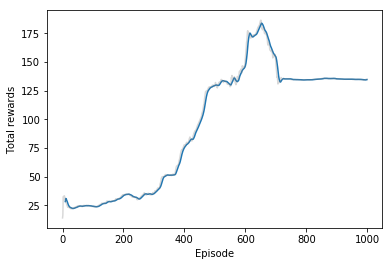

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

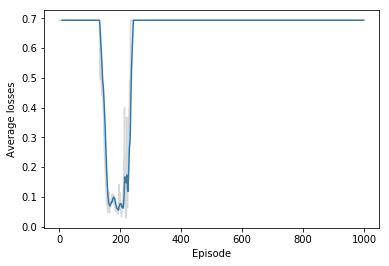

In [48]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [49]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.